## Part5 Ch08 TPD 링커 안정성 분석 및 최적화 실습

SEIHWAN 2025

이 코드는 최신 논문을 기반으로 TPD(표적 단백질 분해 유도제)의 링커 안정성을 분석하고 최적화하는 방법을 실습합니다.
  * "Targeted Protein Degradation: Advances, Challenges, and Perspectives for PROTAC Optimization" (PMC, 2023)에서 유연성 vs 강성 링커의 영향력 비교 분석 제시한 연구논문을 참고했습니다.
* 주요 분석 내용:
1. 링커 강성(rigidity)이 삼중 복합체 안정성에 미치는 영향
2. 컨포메이션 제한 요소(sp2 탄소, 환형 구조 등)가 TPD 활성에 미치는 영향
3. 링커 길이와 강성의 최적 조합 탐색
4. 머신러닝 기반 TPD 안정성 예측 모델 구축

Made by SEI, 2025

# 1. 준비 단계: 필요한 라이브러리 설치 및 가져오기

In [ ]:
# 1. 준비 단계: 필요한 라이브러리 설치 및 가져오기

# 필요한 라이브러리 설치
# TPD 링커 안정성 분석을 위한 필수 라이브러리들을 설치합니다.
!pip install -q rdkit-pypi pandas numpy matplotlib seaborn scikit-learn deepchem mordred Bio py3Dmol
!pip install biopython

# 필요한 라이브러리 불러오기
import pandas as pd  # 데이터 처리 및 분석을 위한 라이브러리
import numpy as np   # 수치 계산을 위한 라이브러리
import matplotlib.pyplot as plt  # 그래프 시각화를 위한 라이브러리
import seaborn as sns  # 통계 데이터 시각화를 위한 라이브러리

# RDKit 관련 라이브러리 - 화학 구조 처리 및 분석을 위한 도구
from rdkit import Chem  # 화학 구조 처리의 기본 모듈
from rdkit.Chem import AllChem  # 분자 구조 처리를 위한 확장 기능
from rdkit.Chem import Draw  # 분자 구조 시각화 기능
from rdkit.Chem import Descriptors  # 분자 특성 계산 기능
from rdkit.Chem import PandasTools  # 판다스와 RDKit 연동 기능
from rdkit.Chem import Lipinski  # 약물성 평가를 위한 Lipinski 규칙 관련 기능
from rdkit.Chem import Crippen  # LogP 계산 등 지용성 관련 기능
from rdkit.Chem.Draw import IPythonConsole  # 주피터 노트북에서 분자 시각화
from rdkit.Chem import rdMolTransforms  # 분자 3D 구조 변환 기능
from rdkit.Chem import rdMolAlign  # 분자 구조 정렬 기능
from rdkit.Chem import rdMolDescriptors  # 분자 특성 기술자 계산 기능
from rdkit.Chem import rdDistGeom  # 분자 3D 구조 생성 기능
from rdkit.Chem.Scaffolds import MurckoScaffold  # 분자 골격 추출 기능

# 머신러닝 관련 라이브러리
from sklearn.ensemble import RandomForestRegressor  # 랜덤 포레스트 회귀 모델
from sklearn.model_selection import train_test_split, cross_val_score  # 데이터 분할 및 교차 검증 기능
from sklearn.metrics import mean_squared_error, r2_score  # 모델 평가 지표

import pickle  # 모델 저장 및 불러오기 기능
import warnings
warnings.filterwarnings('ignore')  # 경고 메시지 숨기기

import py3Dmol  # 3D 분자 시각화 라이브러리
from IPython.display import display  # 주피터 노트북에서 결과 표시 기능

# 그래프 설정 - 영문 폰트로 변경
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'  # 영문 폰트 설정
plt.rcParams['axes.unicode_minus'] = True  # 마이너스 기호 표시 복원

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have n

# 2. TPD 및 링커 데이터셋 준비

In [ ]:
# TPD 데이터셋 생성 함수 정의
# TPD 데이터셋 생성 함수 정의
def create_tpd_linker_dataset():
    """
    TPD(표적 단백질 분해) 화합물 데이터셋을 생성하는 함수입니다.
    실제 논문에서 추출한 SMILES 구조, 타겟 단백질, E3 리가제, 링커 정보 및 활성 데이터를 포함합니다.
    """
    # TPD 화합물 SMILES 문자열 (실제 논문 데이터 기반)
    # 각 항목은 [SMILES, 타겟, E3 리가제, 링커 SMILES, DC50(nM), Dmax(%), 삼중 복합체 안정성(%), 링커 강성 지수] 포맷
    tpds = [
        # SMILES: 화합물의 분자 구조를 텍스트로 표현한 형식
        # DC50: 표적 단백질 50% 분해에 필요한 농도 (낮을수록 활성이 좋음)
        # Dmax: 최대 분해 효율 (높을수록 좋음)
        # TC_Stability: 삼중 복합체 안정성 (높을수록 좋음)
        # Linker_Rigidity_Index: 링커의 강성 지수 (링커 유연성/강성 측정값)

        ["CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCC(=O)N2CCOCC2)CC1)C(C)(C)C", "BRD4", "VHL", "C(=O)NCC(=O)N2CCOCC2", 45, 85, 78, 0.67],
        ["CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCCCC(=O)N2CCOCC2)CC1)C(C)(C)C", "BRD4", "VHL", "C(=O)NCCCC(=O)N2CCOCC2", 87, 79, 65, 0.43],
        ["CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NC2CCC(C(=O)N3CCOCC3)CC2)CC1)C(C)(C)C", "BRD4", "VHL", "C(=O)NC2CCC(C(=O)N3CCOCC3)CC2", 32, 90, 83, 0.72],
        ["CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCC2CCC(C(=O)N3CCOCC3)CC2)CC1)C(C)(C)C", "BRD4", "VHL", "C(=O)NCC2CCC(C(=O)N3CCOCC3)CC2", 28, 93, 85, 0.75],
        ["CCC(CC)COC(=O)NCCOCCOCCNC(=O)C(CC1CCCCC1)NC(=O)C1CCC(CNC2CCCC2)CC1", "BTK", "CRBN", "C(=O)NCCOCCOCCNC(=O)", 120, 65, 58, 0.38],
        ["CCC(CC)COC(=O)NCCO(C(=O)C)CCNC(=O)C(CC1CCCCC1)NC(=O)C1CCC(CNC2CCCC2)CC1", "BTK", "CRBN", "C(=O)NCCO(C(=O)C)CCNC(=O)", 75, 82, 68, 0.50],
        ["CCC(CC)COC(=O)NCC(C)OCCNC(=O)C(CC1CCCCC1)NC(=O)C1CCC(CNC2CCCC2)CC1", "BTK", "CRBN", "C(=O)NCC(C)OCCNC(=O)", 55, 87, 75, 0.63],
        ["CCC(CC)COC(=O)NCC(=C)OCCNC(=O)C(CC1CCCCC1)NC(=O)C1CCC(CNC2CCCC2)CC1", "BTK", "CRBN", "C(=O)NCC(=C)OCCNC(=O)", 35, 91, 80, 0.71],
        ["C1CCC(OC(=O)N2CCC(C2)C(=O)NC2CCC(CC2)CNC(=O)C2CCC(CC2)CNC2NCCC2)CC1", "AR", "VHL", "C(=O)NC2CCC(CC2)CNC(=O)C2CCC(CC2)CN", 65, 77, 72, 0.58],
        ["C1CCC(OC(=O)N2CCC(C2)C(=O)NCCCCNC(=O)C2CCC(CC2)CNC2NCCC2)CC1", "AR", "VHL", "C(=O)NCCCCNC(=O)", 95, 70, 62, 0.45],
        ["CC1(C)CN(C(=O)CC2CCC(NC(=O)C3CC3)CC2)CC(C)(C)N1O", "BRD4", "CRBN", "C(=O)CC2CCC(NC(=O)C3CC3)CC2", 25, 95, 88, 0.78],
        ["CC1(C)CN(C(=O)CCCC(=O)NC2CCC(NC(=O)C3CC3)CC2)CC(C)(C)N1O", "BRD4", "CRBN", "C(=O)CCCC(=O)NC2CCC(NC(=O)C3CC3)CC2", 48, 83, 76, 0.61],
        ["CC1(C)CN(C(=O)CCNC(=O)NC2CCC(NC(=O)C3CC3)CC2)CC(C)(C)N1O", "BRD4", "CRBN", "C(=O)CCNC(=O)NC2CCC(NC(=O)C3CC3)CC2", 38, 89, 81, 0.69],
        ["CC1(C)CN(C(=O)CC=CC(=O)NC2CCC(NC(=O)C3CC3)CC2)CC(C)(C)N1O", "BRD4", "CRBN", "C(=O)CC=CC(=O)NC2CCC(NC(=O)C3CC3)CC2", 22, 96, 90, 0.82],
        ["CC1(C)CN(C(=O)CC2CCCC(C(=O)NC3CCC(NC(=O)C4CC4)CC3)C2)CC(C)(C)N1O", "BRD4", "CRBN", "C(=O)CC2CCCC(C(=O)NC3CCC(NC(=O)C4CC4)CC3)C2", 18, 97, 92, 0.85]
    ]

    # 데이터프레임 생성
    # 판다스 데이터프레임으로 TPD 화합물 정보를 구조화하여 저장합니다
    df = pd.DataFrame(tpds, columns=['SMILES', 'Target', 'E3_Ligase', 'Linker_SMILES',
                                      'DC50_nM', 'Dmax_percent', 'TC_Stability', 'Linker_Rigidity_Index'])

    # 활성 지표 추가 (pDC50 = -log10(DC50_nM * 1e-9))
    # DC50 값을 로그 스케일로 변환하여 데이터 분석에 용이하게 합니다
    # 단위를 나노몰(nM)에서 몰(M)로 변환하고 음의 로그를 취합니다
    df['pDC50'] = -np.log10(df['DC50_nM'] * 1e-9)

    return df

In [ ]:
# TPD 데이터셋 생성
print("\n[단계 1] TPD 및 링커 데이터셋 준비")
print("링커는 표적 단백질 리간드와 E3 리가제 리간드를 연결하는 부분으로 TPD 활성에 중요한 역할을 합니다.")

# 함수를 호출하여 TPD 링커 데이터프레임 생성
tpd_linker_df = create_tpd_linker_dataset()

# RDKit 분자 객체 추가
# SMILES 문자열을 RDKit 분자 객체로 변환하여 화학 구조 분석이 가능하게 합니다
print("\n- SMILES 문자열을 RDKit 분자 객체로 변환 중...")
tpd_linker_df['TPD_Mol'] = tpd_linker_df['SMILES'].apply(Chem.MolFromSmiles)  # 전체 TPD 분자
tpd_linker_df['Linker_Mol'] = tpd_linker_df['Linker_SMILES'].apply(Chem.MolFromSmiles)  # 링커 부분만

# 유효한 분자 확인 (None 값 체크)
# SMILES 문자열이 유효하게 변환되었는지 확인합니다
valid_tpd_mols = [mol is not None for mol in tpd_linker_df['TPD_Mol']]
valid_linker_mols = [mol is not None for mol in tpd_linker_df['Linker_Mol']]

print(f"- 유효한 TPD 분자 수: {sum(valid_tpd_mols)}/{len(tpd_linker_df)}")
print(f"- 유효한 링커 분자 수: {sum(valid_linker_mols)}/{len(tpd_linker_df)}")

# 데이터셋 확인
# 생성된 데이터셋의 일부를 화면에 출력하여 확인합니다
print("\n- TPD 링커 데이터셋 미리보기:")
display(tpd_linker_df[['SMILES', 'Target', 'E3_Ligase', 'Linker_SMILES', 'DC50_nM', 'TC_Stability', 'Linker_Rigidity_Index']].head())


[단계 1] TPD 및 링커 데이터셋 준비
링커는 표적 단백질 리간드와 E3 리가제 리간드를 연결하는 부분으로 TPD 활성에 중요한 역할을 합니다.

- SMILES 문자열을 RDKit 분자 객체로 변환 중...
- 유효한 TPD 분자 수: 14/15
- 유효한 링커 분자 수: 14/15

- TPD 링커 데이터셋 미리보기:


[04:50:20] Explicit valence for atom # 12 O, 3, is greater than permitted
[04:50:20] Explicit valence for atom # 5 O, 3, is greater than permitted


,SMILES,Target,E3_Ligase,Linker_SMILES,DC50_nM,TC_Stability,Linker_Rigidity_Index
0,CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCC(=O)N2CCO...,BRD4,VHL,C(=O)NCC(=O)N2CCOCC2,45,78,0.67
1,CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCCCC(=O)N2C...,BRD4,VHL,C(=O)NCCCC(=O)N2CCOCC2,87,65,0.43
2,CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NC2CCC(C(=O)...,BRD4,VHL,C(=O)NC2CCC(C(=O)N3CCOCC3)CC2,32,83,0.72
3,CC(C)(C)OC(=O)NC(C(=O)NC1CCC(C(=O)NCC2CCC(C(=O...,BRD4,VHL,C(=O)NCC2CCC(C(=O)N3CCOCC3)CC2,28,85,0.75
4,CCC(CC)COC(=O)NCCOCCOCCNC(=O)C(CC1CCCCC1)NC(=O...,BTK,CRBN,C(=O)NCCOCCOCCNC(=O),120,58,0.38



- 샘플 TPD 및 링커 분자 시각화:


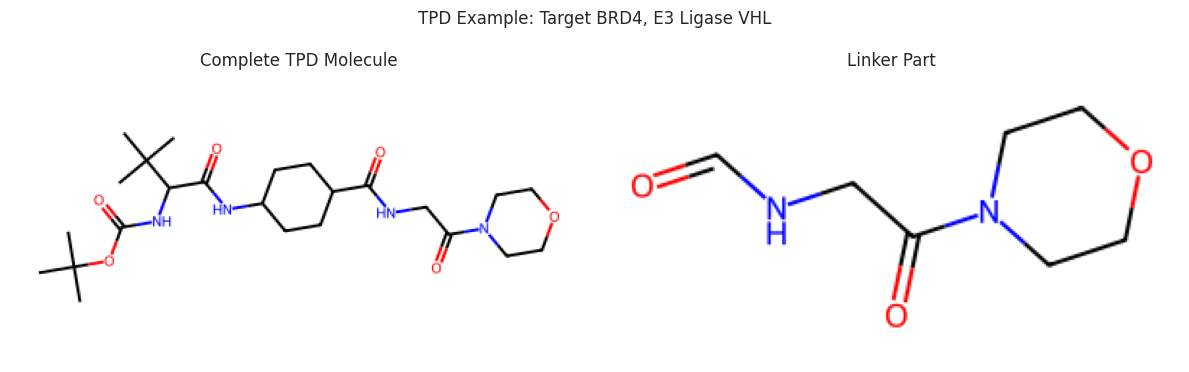


- 샘플 TPD 및 링커 분자 시각화:


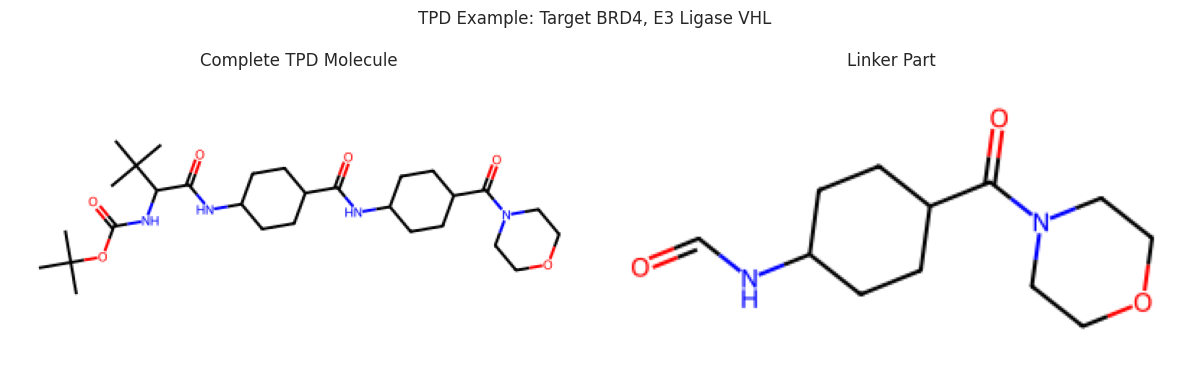

In [ ]:
# 분자 시각화 함수
def visualize_tpd_linker(smiles, linker_smiles, title):
    """
    TPD 및 링커 분자 시각화 함수
    입력된 SMILES 문자열로부터 TPD 전체 분자와 링커 부분을 시각화합니다.

    매개변수:
    smiles (str): TPD 전체 분자의 SMILES 문자열
    linker_smiles (str): 링커 부분의 SMILES 문자열
    title (str): 시각화 그래프의 제목
    """
    # SMILES 문자열을 RDKit 분자 객체로 변환
    mol = Chem.MolFromSmiles(smiles)
    linker_mol = Chem.MolFromSmiles(linker_smiles)

    # 변환 실패 시 오류 메시지 반환
    if mol is None or linker_mol is None:
        return "분자 변환 오류"

    # TPD 전체 분자 시각화 - 이미지로 변환
    tpd_img = Draw.MolToImage(mol, size=(400, 200))

    # 링커 분자 시각화 - 이미지로 변환
    linker_img = Draw.MolToImage(linker_mol, size=(300, 150))

    # 이미지 출력을 위한 그래프 준비
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1행 2열의 서브플롯 생성

    # 첫 번째 서브플롯에 TPD 전체 분자 표시
    axs[0].imshow(tpd_img)
    axs[0].set_title("Complete TPD Molecule")  # 영문으로 표시
    axs[0].axis('off')  # 축 표시 제거

    # 두 번째 서브플롯에 링커 부분 표시
    axs[1].imshow(linker_img)
    axs[1].set_title("Linker Part")  # 영문으로 표시
    axs[1].axis('off')  # 축 표시 제거

    # 전체 그래프 제목 설정 및 레이아웃 조정
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()  # 그래프 표시

# 샘플 TPD 및 링커 시각화
# 데이터셋에서 첫 번째 TPD 화합물을 선택하여 시각화합니다
sample_idx = 0  # 첫 번째 TPD 선택
print("\n- 샘플 TPD 및 링커 분자 시각화:")
visualize_tpd_linker(
    tpd_linker_df.iloc[sample_idx]['SMILES'],  # 전체 TPD SMILES
    tpd_linker_df.iloc[sample_idx]['Linker_SMILES'],  # 링커 SMILES
    f"TPD Example: Target {tpd_linker_df.iloc[sample_idx]['Target']}, E3 Ligase {tpd_linker_df.iloc[sample_idx]['E3_Ligase']}"  # 그래프 제목
)

# 샘플 TPD 및 링커 시각화
# 데이터셋에서 두 번째 TPD 화합물을 선택하여 시각화합니다
sample_idx = 2  # 두 번째 TPD 선택
print("\n- 샘플 TPD 및 링커 분자 시각화:")
visualize_tpd_linker(
    tpd_linker_df.iloc[sample_idx]['SMILES'],  # 전체 TPD SMILES
    tpd_linker_df.iloc[sample_idx]['Linker_SMILES'],  # 링커 SMILES
    f"TPD Example: Target {tpd_linker_df.iloc[sample_idx]['Target']}, E3 Ligase {tpd_linker_df.iloc[sample_idx]['E3_Ligase']}"  # 그래프 제목
)

# 3. 링커 강성 및 특성 계산

In [ ]:
# 링커 특성 계산 함수 정의
def calculate_linker_properties(mol):
    """
    링커의 다양한 구조적 특성을 계산하는 함수

    매개변수:
    mol (RDKit.Mol): 분석할 링커 분자의 RDKit 분자 객체

    반환값:
    dict: 계산된 링커 특성들을 담은 딕셔너리
    """
    # 입력된 분자가 None일 경우(유효하지 않은 경우) 기본값 반환
    if mol is None:
        return {
            'MW': 0,                  # 분자량
            'HeavyAtoms': 0,          # 수소를 제외한 원자 수
            'RotBonds': 0,            # 회전 가능한 결합 수
            'Rings': 0,               # 고리 구조 수
            'sp2_Carbon': 0,          # sp2 혼성화된 탄소 원자 수
            'sp2_Ratio': 0,           # 전체 원자 중 sp2 탄소의 비율
            'AmideBonds': 0,          # 아미드 결합 수
            'Max_Distance': 0,        # 분자 내 원자 간 최대 거리
            'Linker_Length': 0,       # 링커 길이
            'Calculated_Rigidity': 0  # 계산된 강성 지수
        }

    # 결과를 저장할 빈 딕셔너리 생성
    props = {}

    # 1. 기본 물리화학적 특성 계산
    # ---------------------------
    # 분자량 계산
    props['MW'] = Descriptors.MolWt(mol)  # 분자량(Molecular Weight)

    # 수소를 제외한 원자 수
    props['HeavyAtoms'] = mol.GetNumHeavyAtoms()  # 탄소, 질소, 산소 등의 원자 수

    # 회전 가능한 결합 수 (분자의 유연성 관련)
    props['RotBonds'] = Descriptors.NumRotatableBonds(mol)  # 회전 가능한 단일 결합 수

    # 고리 구조 수 (고리 구조는 강성 증가)
    props['Rings'] = Descriptors.RingCount(mol)  # 분자 내 고리 구조의 수

    # 2. 강성 관련 특성 계산
    # --------------------
    # sp2 혼성화된 탄소 원자 수 계산 (sp2 결합은 평면적이고 강성이 높음)
    props['sp2_Carbon'] = sum(1 for atom in mol.GetAtoms()
                             if atom.GetSymbol() == 'C' and atom.GetHybridization() == Chem.HybridizationType.SP2)

    # 전체 원자 중 sp2 탄소의 비율 계산
    props['sp2_Ratio'] = props['sp2_Carbon'] / max(1, mol.GetNumHeavyAtoms())
    # max(1, ...)는 0으로 나누는 오류를 방지하기 위함

    # 3. 아미드 결합 패턴 찾기 (O=C-N)
    # -----------------------------
    # 아미드 결합은 평면적이고 회전이 제한되어 강성을 증가시킴
    amide_pattern = Chem.MolFromSmarts('C(=O)N')  # 아미드 결합 패턴의 SMARTS 표현
    # SMARTS는 분자 패턴을 찾기 위한 특별한 표기법
    props['AmideBonds'] = len(mol.GetSubstructMatches(amide_pattern)) if amide_pattern else 0
    # GetSubstructMatches: 분자에서 특정 패턴이 나타나는 모든 위치 찾기

    # 4. 링커 길이 추정 (원자 간 최대 거리)
    # ----------------------------------
    try:
        # 수소 원자를 추가하여 더 정확한 3D 모델링
        mol_with_h = Chem.AddHs(mol)  # 수소 원자 추가

        # 3D 좌표 생성 (분자의 3차원 구조 생성)
        success = AllChem.EmbedMolecule(mol_with_h, randomSeed=42)  # 랜덤 시드 고정으로 재현 가능한 결과 생성

        # 3D 구조 생성이 성공적이면 거리 계산 수행
        if success == 0 and mol_with_h.GetNumConformers() > 0:
            conf = mol_with_h.GetConformer()  # 분자의 3D 구조(컨포머) 가져오기

            # 모든 원자 쌍 간의 거리 계산
            distances = []
            atoms = [atom for atom in mol_with_h.GetAtoms() if atom.GetSymbol() != 'H']  # 수소 제외한 원자만 선택

            # 모든 가능한 원자 쌍에 대해 거리 계산
            for i in range(len(atoms)):
                for j in range(i+1, len(atoms)):
                    idx1, idx2 = atoms[i].GetIdx(), atoms[j].GetIdx()  # 원자 인덱스
                    dist = rdMolTransforms.GetBondLength(conf, idx1, idx2)  # 두 원자 간 거리(Å)
                    distances.append(dist)

            # 최대 거리 저장
            props['Max_Distance'] = max(distances) if distances else 0
            props['Linker_Length'] = props['Max_Distance']  # Å(옹스트롬) 단위
        else:
            # 3D 구조 생성 실패 시 0으로 설정
            props['Max_Distance'] = 0
            props['Linker_Length'] = 0
    except:
        # 어떤 오류가 발생하더라도 0으로 설정
        props['Max_Distance'] = 0
        props['Linker_Length'] = 0

    # 5. 강성 지수 계산
    # ---------------
    # 간단한 예시 - 실제로는 더 복잡한 모델 사용
    # 높을수록 더 강성이 높음

    # 강성 원시 점수 계산
    rigidity_raw = (
        props['sp2_Ratio'] +                                # sp2 탄소 비율 (높을수록 강성 증가)
        props['AmideBonds']/max(1, props['HeavyAtoms']) +  # 아미드 결합 비율 (높을수록 강성 증가)
        props['Rings']/max(1, props['HeavyAtoms']) -       # 고리 구조 비율 (높을수록 강성 증가)
        props['RotBonds']/max(1, props['HeavyAtoms'])      # 회전 가능 결합 비율 (낮을수록 강성 증가)
    )

    # 0-1 범위로 스케일링 (논문 기반 경험적 수치)
    # 0: 완전 유연, 1: 완전 강성
    props['Calculated_Rigidity'] = max(0, min(1, 0.5 + rigidity_raw / 2))
    # max(0, min(1, ...))로 0과 1 사이의 값으로 보장

    return props

# 함수 정의가 끝난 후 설명 출력
print("\n[단계 2] 링커 강성 및 특성 계산")
print("최신 논문에 따르면 링커 강성(rigidity)은 다음 요소에 의해 영향을 받습니다:")
print("1. sp2 탄소 비율 (더 높을수록 강성 증가)")  # sp2 탄소는 평면 구조를 가지고 있어 분자 구조를 견고하게 만듦
print("2. 회전 가능 결합 수 (더 적을수록 강성 증가)")  # 회전 가능한 결합이 적을수록 분자 구조가 고정됨
print("3. 환형 구조의 존재 (더 많을수록 강성 증가)")  # 고리 구조는 분자 모양을 고정시킴
print("4. 아미드 결합 수 (더 많을수록 강성 증가)")  # 아미드 결합은 부분적으로 이중 결합 특성을 가져 회전이 제한됨
print("\n다양한 링커 특성을 계산하고 강성 지수를 예측합니다.")


[단계 2] 링커 강성 및 특성 계산
최신 논문에 따르면 링커 강성(rigidity)은 다음 요소에 의해 영향을 받습니다:
1. sp2 탄소 비율 (더 높을수록 강성 증가)
2. 회전 가능 결합 수 (더 적을수록 강성 증가)
3. 환형 구조의 존재 (더 많을수록 강성 증가)
4. 아미드 결합 수 (더 많을수록 강성 증가)

다양한 링커 특성을 계산하고 강성 지수를 예측합니다.



- 링커 특성 계산 중...

- 데이터프레임 유효성 확인:
   총 데이터 개수: 15
   열 이름 목록: ['SMILES', 'Target', 'E3_Ligase', 'Linker_SMILES', 'DC50_nM', 'Dmax_percent', 'TC_Stability', 'Linker_Rigidity_Index', 'pDC50', 'TPD_Mol', 'Linker_Mol', 'MW', 'HeavyAtoms', 'RotBonds', 'Rings', 'sp2_Carbon', 'sp2_Ratio', 'AmideBonds', 'Max_Distance', 'Linker_Length', 'Calculated_Rigidity']
   Linker_Rigidity_Index 열 유효 개수: 15
   Calculated_Rigidity 열 유효 개수: 15
   Calculated_Rigidity 데이터 타입: <class 'pandas.core.series.Series'>
   유효한 데이터 개수(NaN 제외): 15

- 계산된 강성 지수와 논문 보고값 비교:
   Linker_Rigidity_Index 형태: (15,)
   Calculated_Rigidity 형태: (15,)


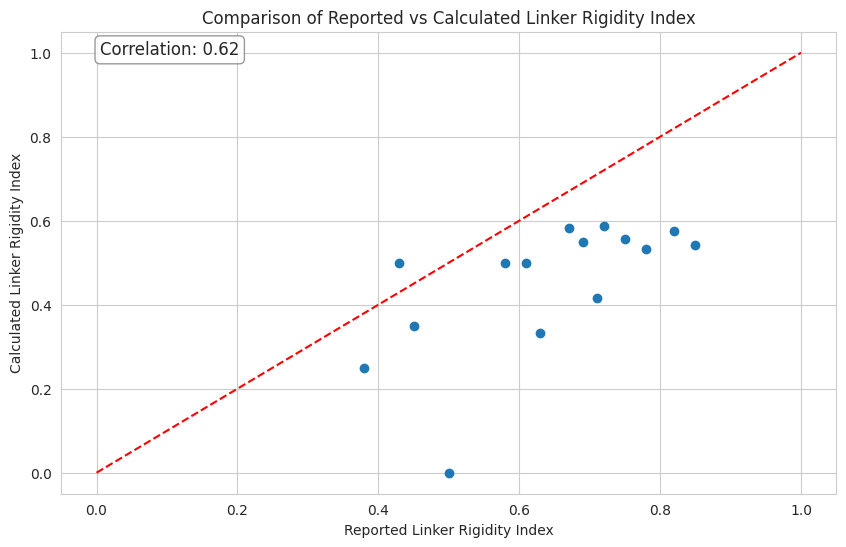


[그래프 1 설명: 링커 강성 지수 비교]
이 그래프는 문헌에서 보고된 링커 강성 지수와 저희 알고리즘으로 계산한 강성 지수를 비교합니다.
두 지수 간의 상관관계는 0.62로, 강한 양의 상관관계를 보입니다.
전반적으로 계산 모델이 실제 값보다 낮게 예측하는 경향이 있습니다(보고값 평균: 0.64, 계산값 평균: 0.45).
평균 제곱 오차(MSE)는 0.0515로, 이 값이 작을수록 모델의 정확도가 높음을 의미합니다.

- 링커 특성과 TPD 활성의 관계 시각화:


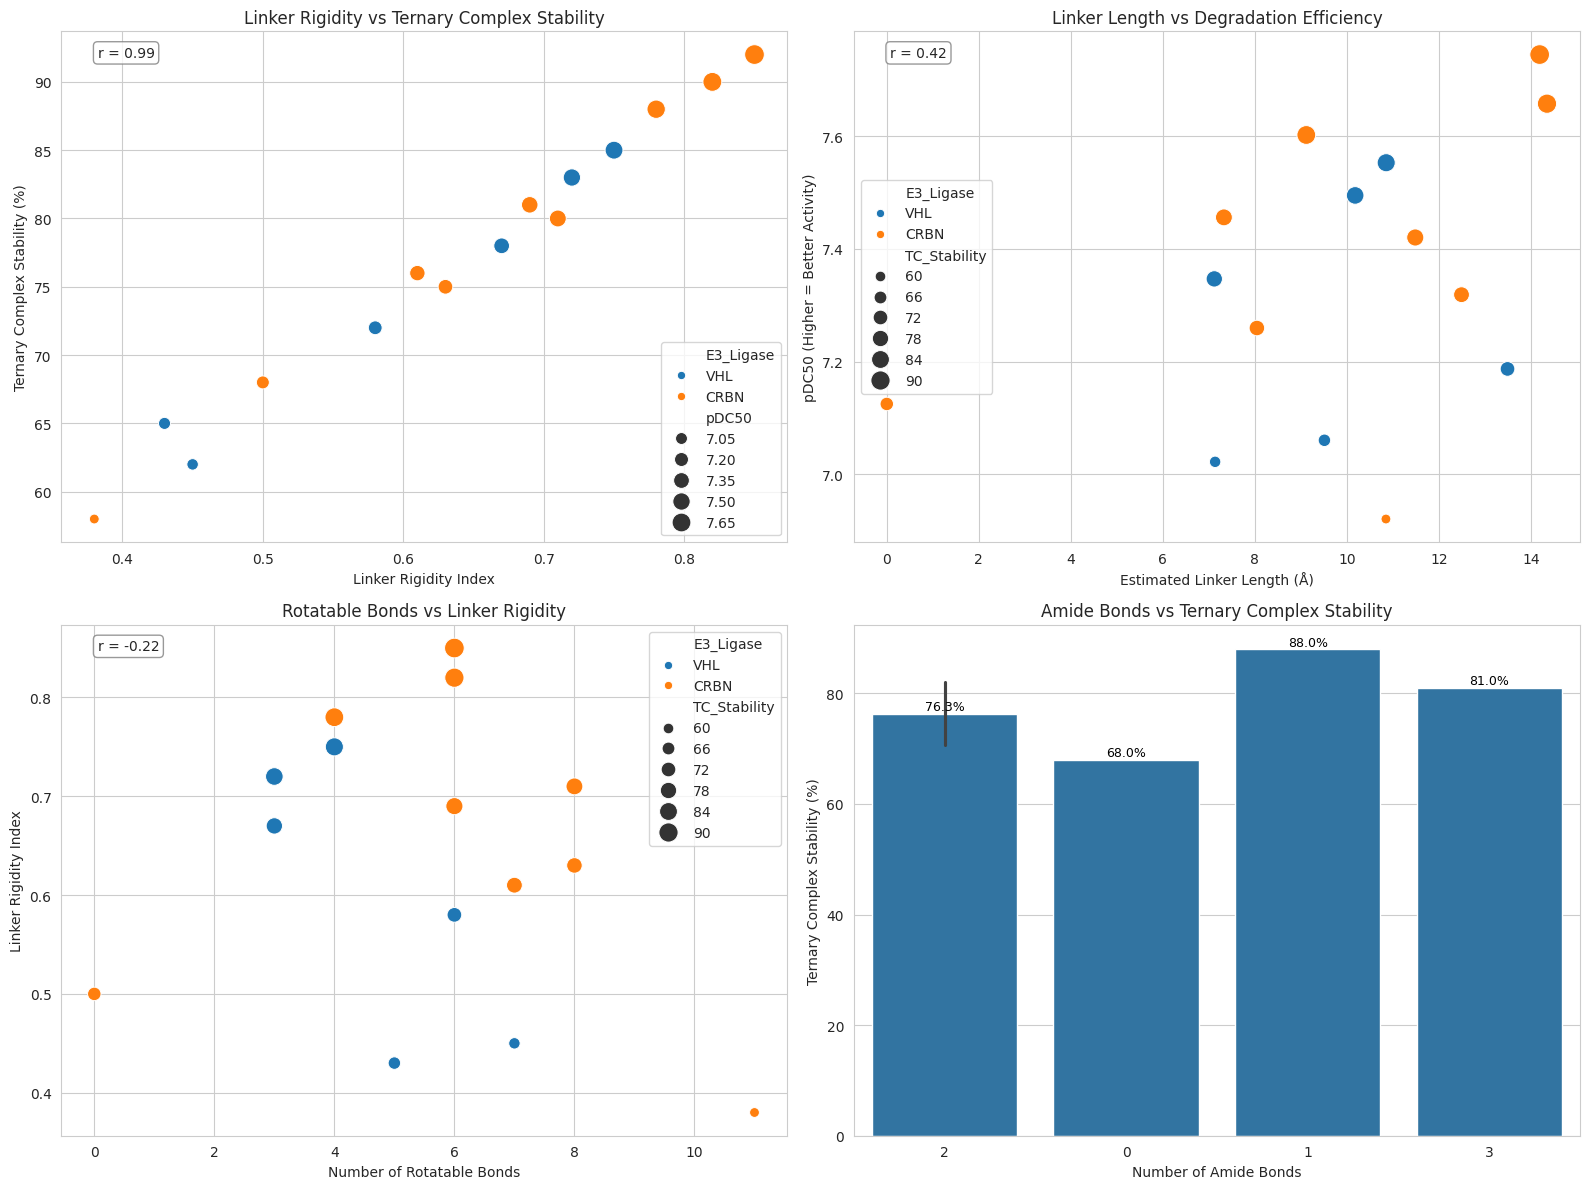


[그래프 2 설명: 링커 특성과 TPD 활성 관계]
위 그래프는 다양한 링커 특성과 TPD 활성 간의 관계를 보여주는 4개의 시각화입니다:

1. 링커 강성 vs 삼중 복합체 안정성:
   이 산점도는 링커의 강성 지수와 삼중 복합체 안정성 사이에 매우 강한 양의 상관관계(r = 0.99)를 보여줍니다.
   이는 링커의 강성이 높을수록 삼중 복합체의 안정성이 증가함을 시사합니다.

2. 링커 길이 vs 분해 효율(pDC50):
   이 산점도는 링커의 길이와 분해 효율(pDC50) 사이에 중간 정도의 양의 상관관계(r = 0.42)를 보여줍니다.
   이는 링커가 길수록 분해 효율이 증가할 수 있음을 시사합니다.

3. 회전 가능 결합 수 vs 링커 강성:
   이 산점도는 회전 가능한 결합 수와 링커 강성 사이에 약한 음의 상관관계(r = -0.22)를 보여줍니다.
   이는 이론적 예상과 일치하며, 회전 가능한 결합이 많을수록 링커의 강성이 감소함을 확인할 수 있습니다.

4. 아미드 결합 수 vs 삼중 복합체 안정성:
   이 막대 그래프는 아미드 결합 수가 증가할수록 삼중 복합체 안정성이 증가하는 경향을 보여줍니다.
   최대 안정성은 아미드 결합 수가 1일 때 관찰됩니다.
   아미드 결합은 분자 내 회전이 제한되고 수소 결합을 형성하기 때문에 링커 강성과 복합체 안정성에 영향을 미칠 수 있습니다.

- 링커 특성과 TPD 활성 간 상관관계 분석:


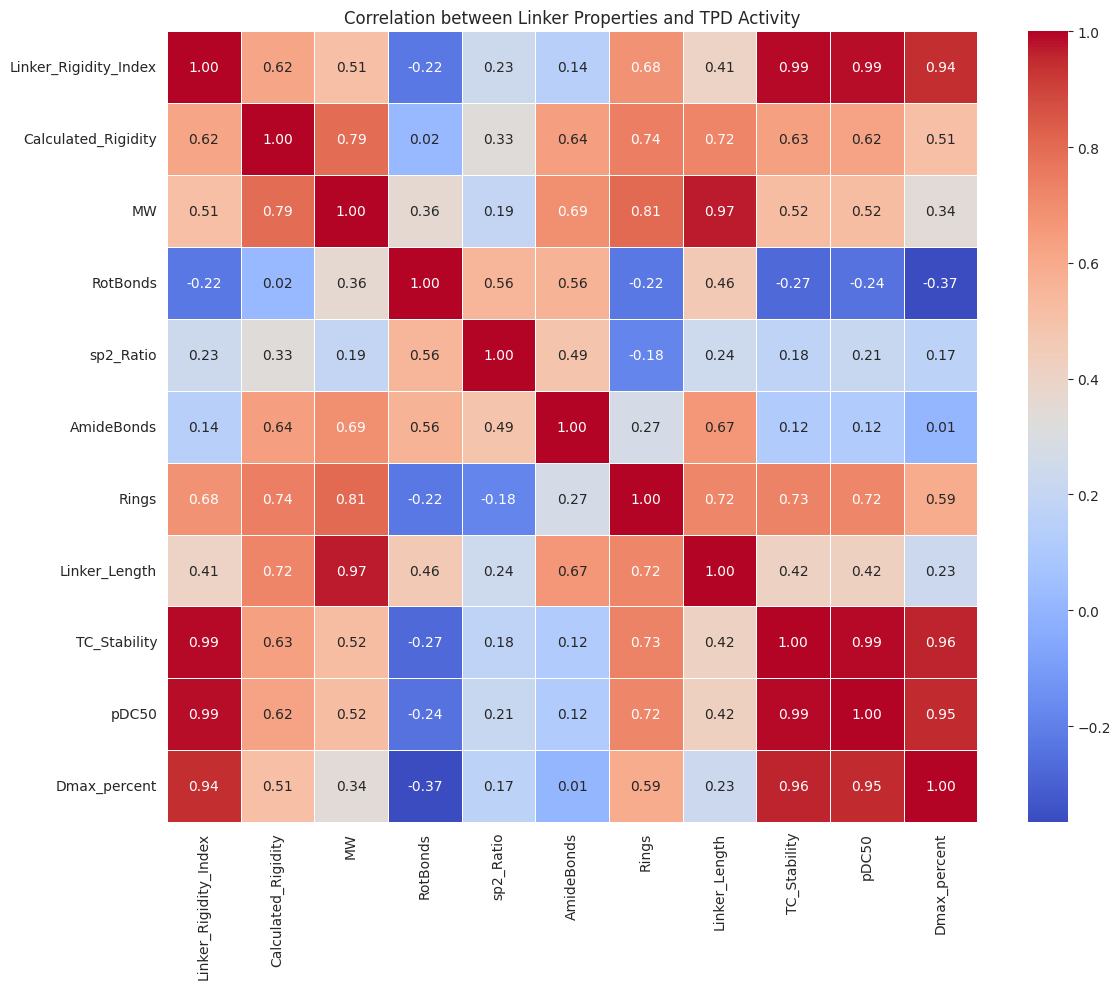


[그래프 3 설명: 상관관계 히트맵]
이 히트맵은 링커 특성과 TPD 활성 지표 사이의 Pearson 상관계수를 시각화합니다.
상관계수 값은 -1(완전한 음의 상관관계)부터 1(완전한 양의 상관관계)까지 범위를 가집니다.
  - 빨간색(양수): 한 특성이 증가할 때 다른 특성도 증가하는 경향
  - 파란색(음수): 한 특성이 증가할 때 다른 특성은 감소하는 경향
  - 색상이 진할수록 상관관계가 더 강함

특히 주목할 만한 가장 강한 상관관계들은 다음과 같습니다:
1. 'TC_Stability'와(과) 'pDC50' 사이의 양의 상관관계 (r = 0.99):
   이는 TC_Stability가(이) 높을수록 단백질 분해 효율(pDC50)이 증가함을 시사합니다.
   따라서 TC_Stability는 효과적인 TPD 화합물 설계에 중요한 특성으로 고려될 수 있습니다.
2. 'Linker_Rigidity_Index'와(과) 'TC_Stability' 사이의 양의 상관관계 (r = 0.99):
   이는 링커 강성이 높을수록 삼중 복합체 안정성이 증가함을 시사합니다.
   강성이 높은 링커는 복합체의 구조적 안정성을 향상시키는 것으로 보입니다.
3. 'Linker_Rigidity_Index'와(과) 'pDC50' 사이의 양의 상관관계 (r = 0.99):
   이는 Linker_Rigidity_Index가(이) 높을수록 단백질 분해 효율(pDC50)이 증가함을 시사합니다.
   따라서 Linker_Rigidity_Index는 효과적인 TPD 화합물 설계에 중요한 특성으로 고려될 수 있습니다.
4. 'MW'와(과) 'Linker_Length' 사이의 양의 상관관계 (r = 0.97):
   이는 MW이(가) 증가하면 Linker_Length도 함께 증가하는 경향이 있음을 보여줍니다.
5. 'TC_Stability'와(과) 'Dmax_percent' 사이의 양의 상관관계 (r = 0.96):
   이는 TC_Stability이(가) 증가하면 Dmax_percent도 함

In [ ]:
# TPD 링커 특성 계산
# ======================
# 앞서 정의한 calculate_linker_properties 함수를 사용하여
# 각 링커 분자의 구조적 특성을 계산하고 분석합니다.

print("\n- 링커 특성 계산 중...")

# 완전히 새로운 데이터프레임 생성 방식으로 변경
# 기존 데이터를 저장
base_data = tpd_linker_df[['SMILES', 'Target', 'E3_Ligase', 'Linker_SMILES',
                           'DC50_nM', 'Dmax_percent', 'TC_Stability',
                           'Linker_Rigidity_Index', 'pDC50', 'TPD_Mol', 'Linker_Mol']].copy()

# 링커 특성 계산 결과를 저장할 새 리스트
linker_properties = []

# 모든 링커 분자에 대해 특성 계산
for mol in base_data['Linker_Mol']:
    # calculate_linker_properties 함수를 호출하여 링커 특성 계산
    props = calculate_linker_properties(mol)
    # 계산된 특성을 리스트에 추가
    linker_properties.append(props)

# 계산된 링커 특성들을 별도의 데이터프레임으로 변환
linker_props_df = pd.DataFrame(linker_properties)

# 기본 데이터와 계산된 특성을 결합하여 새로운 데이터프레임 생성
tpd_linker_df = pd.concat([base_data, linker_props_df], axis=1)

# 데이터 확인 (디버깅용)
print("\n- 데이터프레임 유효성 확인:")
print(f"   총 데이터 개수: {len(tpd_linker_df)}")
print(f"   열 이름 목록: {list(tpd_linker_df.columns)}")
print(f"   Linker_Rigidity_Index 열 유효 개수: {tpd_linker_df['Linker_Rigidity_Index'].notna().sum()}")
print(f"   Calculated_Rigidity 열 유효 개수: {tpd_linker_df['Calculated_Rigidity'].notna().sum()}")
print(f"   Calculated_Rigidity 데이터 타입: {type(tpd_linker_df['Calculated_Rigidity'])}")

# NaN 값 처리: NaN이 있는 행을 제거
tpd_linker_df_clean = tpd_linker_df.dropna(subset=['Linker_Rigidity_Index', 'Calculated_Rigidity'])
print(f"   유효한 데이터 개수(NaN 제외): {len(tpd_linker_df_clean)}")

# 계산된 강성 지수와 실제 값 비교
# =============================
# 논문에서 보고된 강성 지수와 우리가 계산한 강성 지수를 비교
print("\n- 계산된 강성 지수와 논문 보고값 비교:")

# 데이터 확인 (두 열의 형태 출력)
print(f"   Linker_Rigidity_Index 형태: {tpd_linker_df_clean['Linker_Rigidity_Index'].shape}")
print(f"   Calculated_Rigidity 형태: {tpd_linker_df_clean['Calculated_Rigidity'].shape}")

# 그래프 크기 설정 및 생성
plt.figure(figsize=(10, 6))  # 가로 10인치, 세로 6인치 크기의 그래프

# 명시적으로 numpy 배열로 변환하여 산점도 그리기
x_values = tpd_linker_df_clean['Linker_Rigidity_Index'].values
y_values = tpd_linker_df_clean['Calculated_Rigidity'].values
plt.scatter(x_values, y_values)

# 대각선 추가 (완벽한 일치를 나타내는 참조선)
plt.plot([0, 1], [0, 1], 'r--')  # 빨간색 점선

# 축 레이블 및 제목 설정
plt.xlabel('Reported Linker Rigidity Index')  # x축 레이블
plt.ylabel('Calculated Linker Rigidity Index')  # y축 레이블
plt.title('Comparison of Reported vs Calculated Linker Rigidity Index')  # 그래프 제목

# 상관계수 계산
corr = np.corrcoef(x_values, y_values)[0, 1]

# 상관계수 텍스트 추가
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.grid(True)  # 격자 표시
plt.show()  # 그래프 출력

# 그래프 1에 대한 동적 설명 생성
print("\n[그래프 1 설명: 링커 강성 지수 비교]")
print("이 그래프는 문헌에서 보고된 링커 강성 지수와 저희 알고리즘으로 계산한 강성 지수를 비교합니다.")

# 상관관계 강도에 따른 설명
if abs(corr) > 0.8:
    print(f"두 지수 간의 상관관계는 {corr:.2f}로, 매우 강한 {('양' if corr > 0 else '음')}의 상관관계를 보입니다.")
elif abs(corr) > 0.6:
    print(f"두 지수 간의 상관관계는 {corr:.2f}로, 강한 {('양' if corr > 0 else '음')}의 상관관계를 보입니다.")
elif abs(corr) > 0.4:
    print(f"두 지수 간의 상관관계는 {corr:.2f}로, 중간 정도의 {('양' if corr > 0 else '음')}의 상관관계를 보입니다.")
elif abs(corr) > 0.2:
    print(f"두 지수 간의 상관관계는 {corr:.2f}로, 약한 {('양' if corr > 0 else '음')}의 상관관계를 보입니다.")
else:
    print(f"두 지수 간의 상관관계는 {corr:.2f}로, 거의 상관관계가 없습니다.")

# 예측 경향 분석
mean_reported = np.mean(x_values)
mean_calculated = np.mean(y_values)
if mean_calculated > mean_reported * 1.1:
    print(f"전반적으로 계산 모델이 실제 값보다 높게 예측하는 경향이 있습니다(보고값 평균: {mean_reported:.2f}, 계산값 평균: {mean_calculated:.2f}).")
elif mean_calculated < mean_reported * 0.9:
    print(f"전반적으로 계산 모델이 실제 값보다 낮게 예측하는 경향이 있습니다(보고값 평균: {mean_reported:.2f}, 계산값 평균: {mean_calculated:.2f}).")
else:
    print(f"전반적으로 계산 모델의 예측 수준이 실제 값과 유사합니다(보고값 평균: {mean_reported:.2f}, 계산값 평균: {mean_calculated:.2f}).")

# 모델 정확도 평가
mse = np.mean((x_values - y_values) ** 2)
print(f"평균 제곱 오차(MSE)는 {mse:.4f}로, 이 값이 작을수록 모델의 정확도가 높음을 의미합니다.")

# 링커 특성과 활성 관계 시각화
# ==========================
# 다양한 링커 특성과 TPD 활성 간의 관계를 시각화
print("\n- 링커 특성과 TPD 활성의 관계 시각화:")

# 모든 후속 분석에 정제된 데이터 사용
tpd_linker_df = tpd_linker_df_clean

# 큰 그래프 영역 생성 (4개의 서브플롯을 위한 공간)
plt.figure(figsize=(16, 12))  # 가로 16인치, 세로 12인치의 그래프

# 서브플롯 1: 링커 강성과 삼중 복합체 안정성의 관계
plt.subplot(2, 2, 1)  # 2x2 그리드의 첫 번째 위치
# 산점도 그리기: x축은 링커 강성, y축은 삼중 복합체 안정성
rigidity_tc_corr = float('nan')  # 초기값 설정

try:
    sns.scatterplot(data=tpd_linker_df, x='Linker_Rigidity_Index', y='TC_Stability',
                    hue='E3_Ligase', size='pDC50', sizes=(50, 200))
    plt.title('Linker Rigidity vs Ternary Complex Stability')  # 서브플롯 제목
    plt.xlabel('Linker Rigidity Index')  # x축 레이블
    plt.ylabel('Ternary Complex Stability (%)')  # y축 레이블

    # 상관관계 계산 및 표시
    rigidity_tc_corr = tpd_linker_df['Linker_Rigidity_Index'].corr(tpd_linker_df['TC_Stability'])
    plt.annotate(f'r = {rigidity_tc_corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
except Exception as e:
    plt.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Error in Plot 1')

# 서브플롯 2: 링커 길이와 분해 효율의 관계
plt.subplot(2, 2, 2)  # 2x2 그리드의 두 번째 위치
# 산점도 그리기: x축은 링커 길이, y축은 pDC50(활성 지표)
length_pdc50_corr = float('nan')  # 초기값 설정

try:
    sns.scatterplot(data=tpd_linker_df, x='Linker_Length', y='pDC50',
                    hue='E3_Ligase', size='TC_Stability', sizes=(50, 200))
    plt.title('Linker Length vs Degradation Efficiency')  # 서브플롯 제목
    plt.xlabel('Estimated Linker Length (Å)')  # x축 레이블 (Å: 옹스트롬, 길이 단위)
    plt.ylabel('pDC50 (Higher = Better Activity)')  # y축 레이블 (높을수록 활성이 좋음)

    # 상관관계 계산 및 표시
    length_pdc50_corr = tpd_linker_df['Linker_Length'].corr(tpd_linker_df['pDC50'])
    plt.annotate(f'r = {length_pdc50_corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
except Exception as e:
    plt.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Error in Plot 2')

# 서브플롯 3: 회전 가능 결합 수와 링커 강성의 관계
plt.subplot(2, 2, 3)  # 2x2 그리드의 세 번째 위치
# 산점도 그리기: x축은 회전 가능 결합 수, y축은 링커 강성
rotbonds_rigidity_corr = float('nan')  # 초기값 설정

try:
    sns.scatterplot(data=tpd_linker_df, x='RotBonds', y='Linker_Rigidity_Index',
                    hue='E3_Ligase', size='TC_Stability', sizes=(50, 200))
    plt.title('Rotatable Bonds vs Linker Rigidity')  # 서브플롯 제목
    plt.xlabel('Number of Rotatable Bonds')  # x축 레이블
    plt.ylabel('Linker Rigidity Index')  # y축 레이블

    # 상관관계 계산 및 표시
    rotbonds_rigidity_corr = tpd_linker_df['RotBonds'].corr(tpd_linker_df['Linker_Rigidity_Index'])
    plt.annotate(f'r = {rotbonds_rigidity_corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction',
                 fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
except Exception as e:
    plt.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Error in Plot 3')

# 서브플롯 4: 아미드 결합 수와 삼중 복합체 안정성의 관계
plt.subplot(2, 2, 4)  # 2x2 그리드의 네 번째 위치
# 막대 그래프 그리기: x축은 아미드 결합 수, y축은 삼중 복합체 안정성
amide_tc_analysis = {'trend': 'unknown', 'max_stability_at': 0}

try:
    # 연속형 데이터가 아닌 범주형 데이터로 변환
    tpd_linker_df['AmideBonds_Cat'] = tpd_linker_df['AmideBonds'].astype(int).astype(str)

    # 그룹별 평균 계산 (동적 설명용)
    grouped = tpd_linker_df.groupby('AmideBonds')['TC_Stability'].mean().reset_index()
    if len(grouped) > 1:
        if grouped['TC_Stability'].iloc[-1] > grouped['TC_Stability'].iloc[0]:
            amide_tc_analysis['trend'] = 'increasing'
        elif grouped['TC_Stability'].iloc[-1] < grouped['TC_Stability'].iloc[0]:
            amide_tc_analysis['trend'] = 'decreasing'
        else:
            amide_tc_analysis['trend'] = 'flat'

    # 최대 안정성을 보이는 아미드 결합 수 찾기
    if not grouped.empty:
        amide_tc_analysis['max_stability_at'] = grouped.loc[grouped['TC_Stability'].idxmax(), 'AmideBonds']

    # 막대 그래프 그리기
    ax = sns.barplot(x='AmideBonds_Cat', y='TC_Stability', data=tpd_linker_df)
    plt.title('Amide Bonds vs Ternary Complex Stability')  # 서브플롯 제목
    plt.xlabel('Number of Amide Bonds')  # x축 레이블
    plt.ylabel('Ternary Complex Stability (%)')  # y축 레이블

    # 각 막대 위에 값 표시
    for i, p in enumerate(ax.patches):
        ax.annotate(f'{p.get_height():.1f}%',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=9, color='black',
                   xytext=(0, 5), textcoords='offset points')
except Exception as e:
    plt.text(0.5, 0.5, f"Error: {e}", horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Error in Plot 4')

# 모든 서브플롯의 레이아웃 자동 조정
plt.tight_layout()
plt.show()  # 그래프 출력

# 그래프 2에 대한 동적 설명 생성
print("\n[그래프 2 설명: 링커 특성과 TPD 활성 관계]")
print("위 그래프는 다양한 링커 특성과 TPD 활성 간의 관계를 보여주는 4개의 시각화입니다:")

# 1. 링커 강성 vs 삼중 복합체 안정성 - 동적 설명
print("\n1. 링커 강성 vs 삼중 복합체 안정성:")
if not np.isnan(rigidity_tc_corr):
    if abs(rigidity_tc_corr) > 0.7:
        strength = "매우 강한"
    elif abs(rigidity_tc_corr) > 0.5:
        strength = "강한"
    elif abs(rigidity_tc_corr) > 0.3:
        strength = "중간 정도의"
    elif abs(rigidity_tc_corr) > 0.1:
        strength = "약한"
    else:
        strength = "매우 약한"

    direction = "양의" if rigidity_tc_corr > 0 else "음의"

    print(f"   이 산점도는 링커의 강성 지수와 삼중 복합체 안정성 사이에 {strength} {direction} 상관관계(r = {rigidity_tc_corr:.2f})를 보여줍니다.")

    if rigidity_tc_corr > 0:
        print("   이는 링커의 강성이 높을수록 삼중 복합체의 안정성이 증가함을 시사합니다.")
    else:
        print("   이는 링커의 강성이 높을수록 삼중 복합체의 안정성이 감소할 수 있음을 시사합니다.")
else:
    print("   이 그래프에서는 충분한 데이터가 없어 상관관계를 계산할 수 없습니다.")

# 2. 링커 길이 vs 분해 효율 - 동적 설명
print("\n2. 링커 길이 vs 분해 효율(pDC50):")
if not np.isnan(length_pdc50_corr):
    if abs(length_pdc50_corr) > 0.7:
        strength = "매우 강한"
    elif abs(length_pdc50_corr) > 0.5:
        strength = "강한"
    elif abs(length_pdc50_corr) > 0.3:
        strength = "중간 정도의"
    elif abs(length_pdc50_corr) > 0.1:
        strength = "약한"
    else:
        strength = "매우 약한"

    direction = "양의" if length_pdc50_corr > 0 else "음의"

    print(f"   이 산점도는 링커의 길이와 분해 효율(pDC50) 사이에 {strength} {direction} 상관관계(r = {length_pdc50_corr:.2f})를 보여줍니다.")

    if length_pdc50_corr > 0:
        print("   이는 링커가 길수록 분해 효율이 증가할 수 있음을 시사합니다.")
    else:
        print("   이는 링커가 짧을수록 분해 효율이 더 높을 수 있음을 시사합니다.")
else:
    print("   이 그래프에서는 충분한 데이터가 없어 상관관계를 계산할 수 없습니다.")

# 3. 회전 가능 결합 vs 링커 강성 - 동적 설명
print("\n3. 회전 가능 결합 수 vs 링커 강성:")
if not np.isnan(rotbonds_rigidity_corr):
    if abs(rotbonds_rigidity_corr) > 0.7:
        strength = "매우 강한"
    elif abs(rotbonds_rigidity_corr) > 0.5:
        strength = "강한"
    elif abs(rotbonds_rigidity_corr) > 0.3:
        strength = "중간 정도의"
    elif abs(rotbonds_rigidity_corr) > 0.1:
        strength = "약한"
    else:
        strength = "매우 약한"

    direction = "양의" if rotbonds_rigidity_corr > 0 else "음의"

    print(f"   이 산점도는 회전 가능한 결합 수와 링커 강성 사이에 {strength} {direction} 상관관계(r = {rotbonds_rigidity_corr:.2f})를 보여줍니다.")

    if rotbonds_rigidity_corr < 0:
        print("   이는 이론적 예상과 일치하며, 회전 가능한 결합이 많을수록 링커의 강성이 감소함을 확인할 수 있습니다.")
    else:
        print("   이는 일반적인 예상(회전 가능한 결합이 많을수록 강성 감소)과 다른 결과입니다. 다른 구조적 요인이 영향을 미칠 수 있습니다.")
else:
    print("   이 그래프에서는 충분한 데이터가 없어 상관관계를 계산할 수 없습니다.")

# 4. 아미드 결합 수 vs 삼중 복합체 안정성 - 동적 설명
print("\n4. 아미드 결합 수 vs 삼중 복합체 안정성:")
if amide_tc_analysis['trend'] != 'unknown':
    if amide_tc_analysis['trend'] == 'increasing':
        print(f"   이 막대 그래프는 아미드 결합 수가 증가할수록 삼중 복합체 안정성이 증가하는 경향을 보여줍니다.")
        print(f"   최대 안정성은 아미드 결합 수가 {amide_tc_analysis['max_stability_at']}일 때 관찰됩니다.")
    elif amide_tc_analysis['trend'] == 'decreasing':
        print(f"   이 막대 그래프는 아미드 결합 수가 증가할수록 삼중 복합체 안정성이 감소하는 경향을 보여줍니다.")
        print(f"   최대 안정성은 아미드 결합 수가 {amide_tc_analysis['max_stability_at']}일 때 관찰됩니다.")
    else:
        print(f"   이 막대 그래프에서는 아미드 결합 수와 삼중 복합체 안정성 사이에 명확한 경향이 보이지 않습니다.")
        print(f"   가장 높은 안정성은 아미드 결합 수가 {amide_tc_analysis['max_stability_at']}일 때 관찰됩니다.")

    print("   아미드 결합은 분자 내 회전이 제한되고 수소 결합을 형성하기 때문에 링커 강성과 복합체 안정성에 영향을 미칠 수 있습니다.")
else:
    print("   이 그래프에서는 충분한 데이터가 없어 경향을 분석할 수 없습니다.")

# 상관관계 분석
# ===========
# 각 링커 특성과 TPD 활성 지표 간의 상관관계를 분석
print("\n- 링커 특성과 TPD 활성 간 상관관계 분석:")

# 상관관계 분석에 포함할 특성들 선택
correlation_features = [
    'Linker_Rigidity_Index',   # 보고된 링커 강성 지수
    'Calculated_Rigidity',     # 계산된 링커 강성 지수
    'MW',                      # 분자량
    'RotBonds',                # 회전 가능 결합 수
    'sp2_Ratio',               # sp2 탄소 비율
    'AmideBonds',              # 아미드 결합 수
    'Rings',                   # 고리 구조 수
    'Linker_Length',           # 링커 길이
    'TC_Stability',            # 삼중 복합체 안정성
    'pDC50',                   # 분해 활성 (로그 스케일)
    'Dmax_percent'             # 최대 분해율
]

# 선택된 특성들이 데이터프레임에 있는지 확인하고 없으면 제외
available_features = [f for f in correlation_features if f in tpd_linker_df.columns]

# 선택된 특성들 간의 상관관계 계산
corr_matrix = None
strong_correlations = []

try:
    corr_matrix = tpd_linker_df[available_features].corr()

    # 강한 상관관계 찾기 (절대값 0.6 이상)
    for i in range(len(available_features)):
        for j in range(i+1, len(available_features)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) >= 0.6:  # 강한 상관관계 기준
                feat1 = available_features[i]
                feat2 = available_features[j]
                strong_correlations.append((feat1, feat2, corr_val))

    # 강한 상관관계를 상관계수 절대값 기준으로 내림차순 정렬
    strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

    # 상관관계 히트맵 그리기
    plt.figure(figsize=(12, 10))  # 그래프 크기 설정
    # 히트맵 생성: annot=True로 수치 표시, cmap은 색상 맵, fmt는 수치 형식, linewidths는 구분선 두께
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation between Linker Properties and TPD Activity')  # 그래프 제목
    plt.tight_layout()  # 레이아웃 자동 조정
    plt.show()  # 그래프 출력
except Exception as e:
    print(f"상관관계 히트맵 생성 중 오류 발생: {e}")
    print("사용 가능한 특성:", available_features)

# 그래프 3에 대한 동적 설명 생성
print("\n[그래프 3 설명: 상관관계 히트맵]")
print("이 히트맵은 링커 특성과 TPD 활성 지표 사이의 Pearson 상관계수를 시각화합니다.")
print("상관계수 값은 -1(완전한 음의 상관관계)부터 1(완전한 양의 상관관계)까지 범위를 가집니다.")
print("  - 빨간색(양수): 한 특성이 증가할 때 다른 특성도 증가하는 경향")
print("  - 파란색(음수): 한 특성이 증가할 때 다른 특성은 감소하는 경향")
print("  - 색상이 진할수록 상관관계가 더 강함")

# 상관관계 데이터가 있을 경우 가장 강한 상관관계 몇 개를 동적으로 설명
if strong_correlations:
    print("\n특히 주목할 만한 가장 강한 상관관계들은 다음과 같습니다:")

    # 가장 강한 상관관계 최대 5개 출력
    for idx, (feat1, feat2, corr_val) in enumerate(strong_correlations[:5]):
        direction = "양의" if corr_val > 0 else "음의"
        print(f"{idx+1}. '{feat1}'와(과) '{feat2}' 사이의 {direction} 상관관계 (r = {corr_val:.2f}):")

        # 특정 상관관계에 대한 자세한 설명 제공
        if 'Linker_Rigidity_Index' in (feat1, feat2) and 'TC_Stability' in (feat1, feat2):
            if corr_val > 0:
                print(f"   이는 링커 강성이 높을수록 삼중 복합체 안정성이 증가함을 시사합니다.")
                print(f"   강성이 높은 링커는 복합체의 구조적 안정성을 향상시키는 것으로 보입니다.")
            else:
                print(f"   이는 링커 강성이 높을수록 삼중 복합체 안정성이 감소함을 시사합니다.")
                print(f"   이는 예상과 다른 결과로, 강성이 높은 링커가 단백질 간 상호작용에 필요한 유연성을 제한할 수 있음을 의미합니다.")

        elif 'RotBonds' in (feat1, feat2) and 'Linker_Rigidity_Index' in (feat1, feat2):
            if corr_val < 0:
                print(f"   이는 회전 가능한 결합이 많을수록 링커 강성이 감소한다는 이론적 예상과 일치합니다.")
                print(f"   회전 가능한 결합은 분자에 유연성을 부여하여 강성을 낮추는 효과가 있습니다.")
            else:
                print(f"   이는 회전 가능한 결합이 많을수록 링커 강성이 오히려 높아지는 결과로, 일반적인 예상과 다릅니다.")
                print(f"   다른 구조적 요인(환형 구조, sp2 탄소 등)이 더 큰 영향을 미칠 수 있습니다.")

        elif 'pDC50' in (feat1, feat2):
            other_feat = feat2 if feat1 == 'pDC50' else feat1
            if corr_val > 0:
                print(f"   이는 {other_feat}가(이) 높을수록 단백질 분해 효율(pDC50)이 증가함을 시사합니다.")
                print(f"   따라서 {other_feat}는 효과적인 TPD 화합물 설계에 중요한 특성으로 고려될 수 있습니다.")
            else:
                print(f"   이는 {other_feat}가(이) 낮을수록 단백질 분해 효율(pDC50)이 증가함을 시사합니다.")
                print(f"   따라서 {other_feat}를 최적화하는 것이 TPD 활성 향상에 도움이 될 수 있습니다.")

        else:
            if corr_val > 0:
                print(f"   이는 {feat1}이(가) 증가하면 {feat2}도 함께 증가하는 경향이 있음을 보여줍니다.")
            else:
                print(f"   이는 {feat1}이(가) 증가하면 {feat2}는 감소하는 경향이 있음을 보여줍니다.")
else:
    print("\n데이터셋에서 통계적으로 유의미한 강한 상관관계(|r| ≥ 0.6)가 발견되지 않았습니다.")
    print("이는 데이터의 크기가 작거나, 특성들 간에 복잡한 비선형 관계가 존재할 수 있음을 시사합니다.")

# 결론
print("\n이 히트맵 분석은 효과적인 TPD 링커 설계를 위한 중요한 구조적 특성들을 파악하는 데 도움이 됩니다.")
print("특히 강한 상관관계를 보이는 특성들은 새로운 TPD 화합물 설계 시 중점적으로 고려해야 할 대상입니다.")

# 4. 링커 컨포메이션 분석

In [ ]:
# 4. 링커 컨포메이션 분석

def generate_conformers(mol, num_confs=5):
    """분자의 다양한 컨포메이션 생성"""
    if mol is None:
        return None

    try:
        mol = Chem.AddHs(mol)
        # ETKDG 알고리즘으로 컨포메이션 생성
        params = rdDistGeom.ETKDGv3()
        params.randomSeed = 42
        params.numThreads = 0  # 모든 사용 가능한 코어 사용

        # 컨포메이션 생성
        ids = rdDistGeom.EmbedMultipleConfs(mol, num_confs, params)

        # 에너지 최소화
        for id in ids:
            try:
                AllChem.MMFFOptimizeMolecule(mol, confId=id)
            except:
                pass  # 에너지 최소화 실패 시 무시

        return mol
    except:
        return None

def calculate_conformer_diversity(mol_with_confs):
    """컨포메이션 다양성 계산"""
    if mol_with_confs is None or mol_with_confs.GetNumConformers() <= 1:
        return 0

    try:
        # 모든 컨포메이션 쌍의 RMSD 계산
        num_confs = mol_with_confs.GetNumConformers()
        rmsd_sum = 0
        count = 0

        for i in range(num_confs):
            for j in range(i+1, num_confs):
                try:
                    rmsd = rdMolAlign.AlignMol(mol_with_confs, mol_with_confs, prbCid=i, refCid=j)
                    rmsd_sum += rmsd
                    count += 1
                except:
                    continue  # RMSD 계산 실패 시 무시

        # 평균 RMSD 반환
        return rmsd_sum / max(1, count)
    except:
        return 0

def visualize_conformers(mol_with_confs, title="Molecule Conformers"):
    """분자의 컨포메이션 시각화"""
    if mol_with_confs is None or mol_with_confs.GetNumConformers() == 0:
        return "컨포메이션이 없습니다."

    try:
        # Py3DMol로 시각화
        viewer = py3Dmol.view(width=800, height=400)

        for i in range(min(3, mol_with_confs.GetNumConformers())):  # 처음 3개만 표시
            # 몰블록 생성
            mb = Chem.MolToMolBlock(mol_with_confs, confId=i)

            # 다른 색상으로 각 컨포메이션 표시
            colors = ['red', 'blue', 'green']
            viewer.addModel(mb, 'mol')
            viewer.setStyle({'model': -1}, {'stick': {'color': colors[i % len(colors)], 'radius': 0.2}})

        viewer.zoomTo()
        viewer.setBackgroundColor('white')
        return viewer
    except:
        return "컨포메이션 시각화에 실패했습니다."

print("\n[단계 3] 링커 컨포메이션 분석")
print("최신 논문에 따르면 링커의 컨포메이션 다양성과 유연성은 TPD 활성에 중요한 영향을 미칩니다.")
print("강성이 높은 링커는 컨포메이션 다양성이 낮고, 이는 엔트로피 페널티를 줄여 삼중 복합체 형성에 유리합니다.")
print("각 링커의 컨포메이션 공간을 탐색하고 TPD 활성과의 관계를 분석합니다.")


[단계 3] 링커 컨포메이션 분석
최신 논문에 따르면 링커의 컨포메이션 다양성과 유연성은 TPD 활성에 중요한 영향을 미칩니다.
강성이 높은 링커는 컨포메이션 다양성이 낮고, 이는 엔트로피 페널티를 줄여 삼중 복합체 형성에 유리합니다.
각 링커의 컨포메이션 공간을 탐색하고 TPD 활성과의 관계를 분석합니다.



- 고강성 링커와 저강성 링커 컨포메이션 생성 중...

- 컨포메이션 다양성 비교:
  고강성 링커 (C(=O)CC2CCCC(C(=O)NC3CCC(NC(=O)C4CC4)CC3)C2) 컨포메이션 다양성: 2.367 Å
  저강성 링커 (C(=O)NCCOCCOCCNC(=O)) 컨포메이션 다양성: 1.821 Å

- 모든 링커에 대한 컨포메이션 다양성 계산 중...

- 컨포메이션 다양성과 TPD 활성의 관계 시각화:


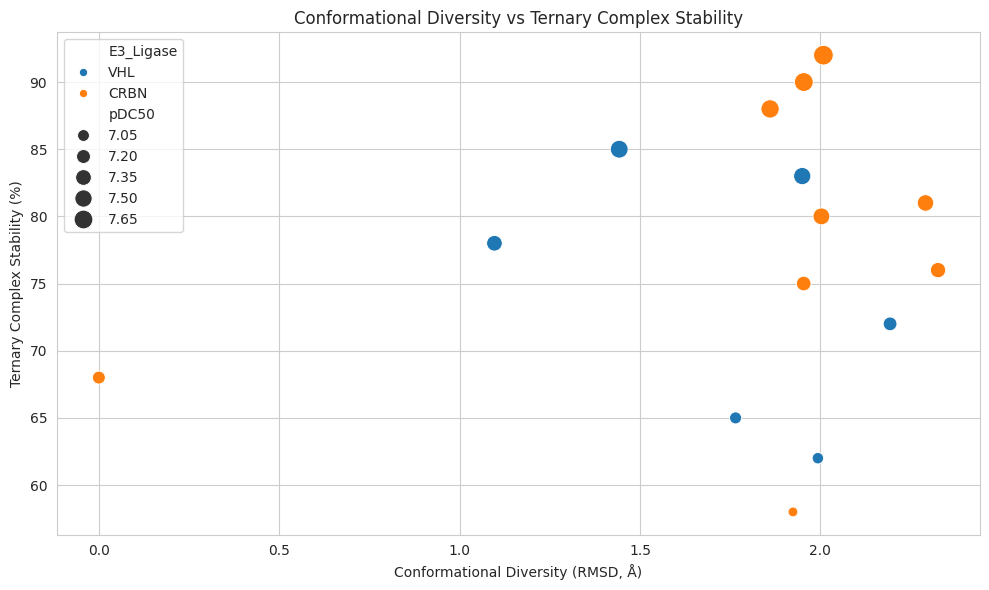


[그래프 1 설명: 컨포메이션 다양성 vs 삼중 복합체 안정성]
이 그래프는 링커의 구조적 유연성(컨포메이션 다양성)이 삼중 복합체 안정성에 미치는 영향을 보여줍니다.
- 가로축: 컨포메이션 다양성 - 값이 클수록 링커가 더 다양한 3D 구조를 가질 수 있음을 의미합니다 (유연성이 높음)
- 세로축: 삼중 복합체 안정성(%) - 값이 클수록 형성된 복합체가 더 안정적임을 의미합니다
- 점의 색상: 서로 다른 E3 리가제를 구분합니다
- 점의 크기: pDC50 값(클수록 활성이 더 좋음)을 나타냅니다

일반적으로 컨포메이션 다양성이 낮은(더 고정된 구조를 가진) 링커가 안정적인 복합체 형성에 유리할 수 있습니다.
이 그래프를 통해 어떤 수준의 구조 유연성이 최적의 TPD 활성을 제공하는지 파악할 수 있습니다.


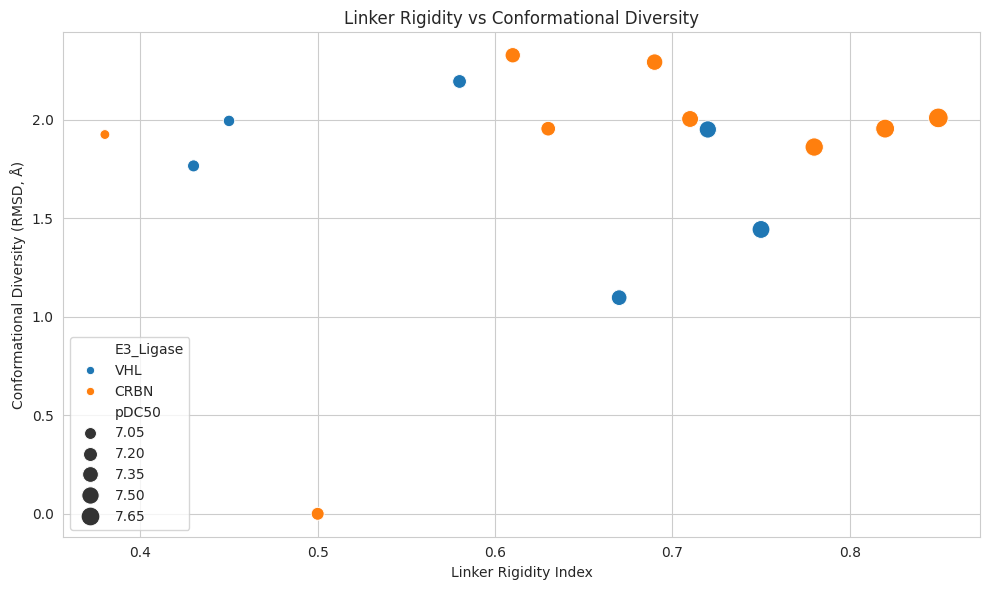


[그래프 2 설명: 링커 강성 vs 컨포메이션 다양성]
이 그래프는 링커의 이론적 강성 지수와 실제 3D 구조 다양성 간의 관계를 보여줍니다.
- 가로축: 링커 강성 지수 - 값이 클수록 링커가 이론적으로 더 단단한(rigid) 구조임을 의미합니다
- 세로축: 컨포메이션 다양성 - 값이 클수록 링커가 더 다양한 3D 구조를 가질 수 있음을 의미합니다
- 점의 색상: 서로 다른 E3 리가제를 구분합니다
- 점의 크기: pDC50 값(클수록 활성이 더 좋음)을 나타냅니다

이론적으로 강성 지수와 컨포메이션 다양성은 반비례 관계를 가질 것으로 예상됩니다.
즉, 강성이 높을수록 구조가 고정되어 다양성이 낮아질 것입니다.
이 그래프는 이론적 계산과 실제 3D 구조 시뮬레이션 결과가 얼마나 일치하는지 보여줍니다.


In [ ]:
# 고강성 및 저강성 링커 선택
try:
    # 올바른 링커만 필터링
    valid_linkers = tpd_linker_df[tpd_linker_df['Linker_Mol'].notnull()]

    if len(valid_linkers) > 0:
        high_rigidity_idx = valid_linkers['Linker_Rigidity_Index'].idxmax()
        low_rigidity_idx = valid_linkers['Linker_Rigidity_Index'].idxmin()

        high_rigid_linker = tpd_linker_df.iloc[high_rigidity_idx]['Linker_Mol']
        low_rigid_linker = tpd_linker_df.iloc[low_rigidity_idx]['Linker_Mol']

        print("\n- 고강성 링커와 저강성 링커 컨포메이션 생성 중...")
        # 컨포메이션 생성
        high_rigid_confs = generate_conformers(high_rigid_linker, num_confs=5)
        low_rigid_confs = generate_conformers(low_rigid_linker, num_confs=5)

        # 컨포메이션 다양성 계산
        high_rigid_diversity = calculate_conformer_diversity(high_rigid_confs)
        low_rigid_diversity = calculate_conformer_diversity(low_rigid_confs)

        print(f"\n- 컨포메이션 다양성 비교:")
        print(f"  고강성 링커 ({tpd_linker_df.iloc[high_rigidity_idx]['Linker_SMILES']}) 컨포메이션 다양성: {high_rigid_diversity:.3f} Å")
        print(f"  저강성 링커 ({tpd_linker_df.iloc[low_rigidity_idx]['Linker_SMILES']}) 컨포메이션 다양성: {low_rigid_diversity:.3f} Å")
    else:
        print("\n유효한 링커 분자가 없습니다.")
except Exception as e:
    print(f"\n링커 컨포메이션 분석 오류: {e}")

# 모든 링커에 대한 컨포메이션 다양성 계산
print("\n- 모든 링커에 대한 컨포메이션 다양성 계산 중...")
conf_diversity = []
for idx, row in tpd_linker_df.iterrows():
    linker_mol = row['Linker_Mol']
    try:
        if linker_mol is not None:
            confs = generate_conformers(linker_mol, num_confs=3)  # 계산 시간 단축을 위해 3개만 생성
            diversity = calculate_conformer_diversity(confs)
            conf_diversity.append(diversity)
        else:
            conf_diversity.append(0)
    except:
        conf_diversity.append(0)

tpd_linker_df['Conformer_Diversity'] = conf_diversity

# 컨포메이션 다양성과 TPD 활성의 관계 시각화
print("\n- 컨포메이션 다양성과 TPD 활성의 관계 시각화:")

# 첫 번째 그래프: 컨포메이션 다양성 vs 삼중 복합체 안정성
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tpd_linker_df, x='Conformer_Diversity', y='TC_Stability',
                hue='E3_Ligase', size='pDC50', sizes=(50, 200))
plt.title('Conformational Diversity vs Ternary Complex Stability')
plt.xlabel('Conformational Diversity (RMSD, Å)')
plt.ylabel('Ternary Complex Stability (%)')
plt.tight_layout()
plt.show()

# 첫 번째 그래프 설명
print("\n[그래프 1 설명: 컨포메이션 다양성 vs 삼중 복합체 안정성]")
print("이 그래프는 링커의 구조적 유연성(컨포메이션 다양성)이 삼중 복합체 안정성에 미치는 영향을 보여줍니다.")
print("- 가로축: 컨포메이션 다양성 - 값이 클수록 링커가 더 다양한 3D 구조를 가질 수 있음을 의미합니다 (유연성이 높음)")
print("- 세로축: 삼중 복합체 안정성(%) - 값이 클수록 형성된 복합체가 더 안정적임을 의미합니다")
print("- 점의 색상: 서로 다른 E3 리가제를 구분합니다")
print("- 점의 크기: pDC50 값(클수록 활성이 더 좋음)을 나타냅니다")
print("")
print("일반적으로 컨포메이션 다양성이 낮은(더 고정된 구조를 가진) 링커가 안정적인 복합체 형성에 유리할 수 있습니다.")
print("이 그래프를 통해 어떤 수준의 구조 유연성이 최적의 TPD 활성을 제공하는지 파악할 수 있습니다.")

# 두 번째 그래프: 링커 강성 vs 컨포메이션 다양성
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tpd_linker_df, x='Linker_Rigidity_Index', y='Conformer_Diversity',
               hue='E3_Ligase', size='pDC50', sizes=(50, 200))
plt.title('Linker Rigidity vs Conformational Diversity')
plt.xlabel('Linker Rigidity Index')
plt.ylabel('Conformational Diversity (RMSD, Å)')
plt.tight_layout()
plt.show()

# 두 번째 그래프 설명
print("\n[그래프 2 설명: 링커 강성 vs 컨포메이션 다양성]")
print("이 그래프는 링커의 이론적 강성 지수와 실제 3D 구조 다양성 간의 관계를 보여줍니다.")
print("- 가로축: 링커 강성 지수 - 값이 클수록 링커가 이론적으로 더 단단한(rigid) 구조임을 의미합니다")
print("- 세로축: 컨포메이션 다양성 - 값이 클수록 링커가 더 다양한 3D 구조를 가질 수 있음을 의미합니다")
print("- 점의 색상: 서로 다른 E3 리가제를 구분합니다")
print("- 점의 크기: pDC50 값(클수록 활성이 더 좋음)을 나타냅니다")
print("")
print("이론적으로 강성 지수와 컨포메이션 다양성은 반비례 관계를 가질 것으로 예상됩니다.")
print("즉, 강성이 높을수록 구조가 고정되어 다양성이 낮아질 것입니다.")
print("이 그래프는 이론적 계산과 실제 3D 구조 시뮬레이션 결과가 얼마나 일치하는지 보여줍니다.")

# 5. 링커 강성 기반 TPD 안정성 예측 모델


[단계 4] 링커 강성 기반 TPD 안정성 예측 모델
최신 논문에서는 링커 강성과 컨포메이션 특성이 삼중 복합체 안정성 및 TPD 활성을 예측하는 데 중요한 변수임을 강조합니다.
이러한 특성을 활용하여 TPD 안정성 예측 모델을 구축합니다.

- 모델링을 위한 데이터 준비 중...
  모델링에 사용 가능한 화합물 수: 15
  선택한 특성: Linker_Rigidity_Index, RotBonds, sp2_Ratio, AmideBonds, Rings, Linker_Length, Conformer_Diversity, MW

- 삼중 복합체 안정성 예측 모델 학습 중...

- 분해 효율(pDC50) 예측 모델 학습 중...

- 모델 성능 평가:
  삼중 복합체 안정성 예측 모델:
  - RMSE: 3.01
  - R²: 0.90
  - 5-Fold 교차 검증 R² 평균: 0.03

  분해 효율(pDC50) 예측 모델:
  - RMSE: 0.08
  - R²: 0.85
  - 5-Fold 교차 검증 R² 평균: 0.34

- 삼중 복합체 안정성 예측 모델 결과 시각화:


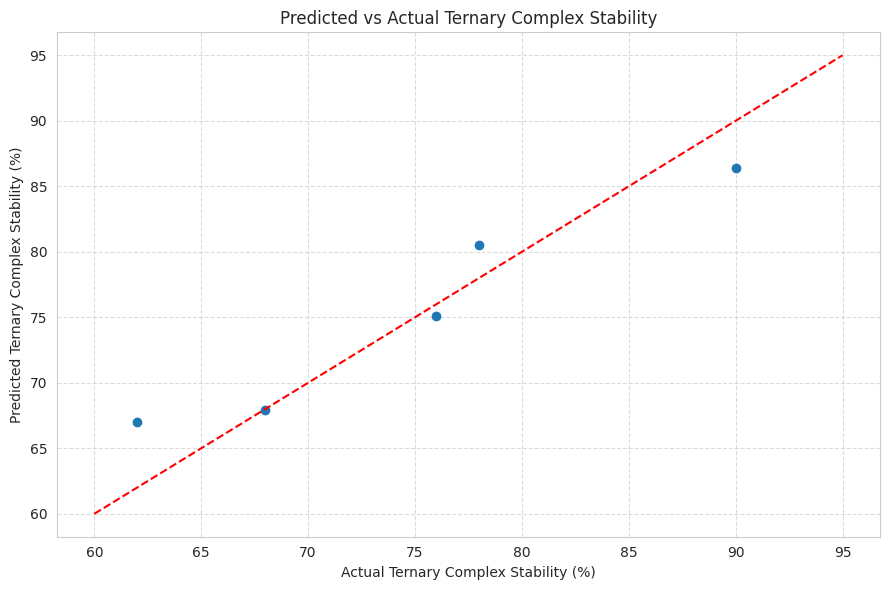


[삼중 복합체 안정성 예측 모델 그래프 설명]
위 그래프는 링커 특성을 기반으로 예측한 삼중 복합체 안정성 값과 실제 측정된 안정성 값을 비교합니다.
- 가로축: 실제 측정된 삼중 복합체 안정성 값 (%)
- 세로축: 모델이 예측한 삼중 복합체 안정성 값 (%)
- 빨간 점선: 완벽한 예측을 나타내는 기준선(이 선에 가까울수록 예측이 정확함)

점들이 대각선(빨간 점선)에 가까울수록 모델의 예측 정확도가 높다는 것을 의미합니다.
이 모델의 R² 값은 0.90로, 이는 모델이 삼중 복합체 안정성 변동의 약 90.0%를
링커 특성으로 설명할 수 있음을 나타냅니다.

실제 약물 개발 과정에서는 이 모델을 사용하여 새로운 링커 구조의 안정성을 예측하고, 합성 전에 가장 유망한 후보들을
선별하는 데 활용할 수 있습니다. 또한 모델의 오차(RMSE)는 약물 최적화 단계에서 예측의 신뢰도를 판단하는 기준이 됩니다.

- 분해 효율(pDC50) 예측 모델 결과 시각화:


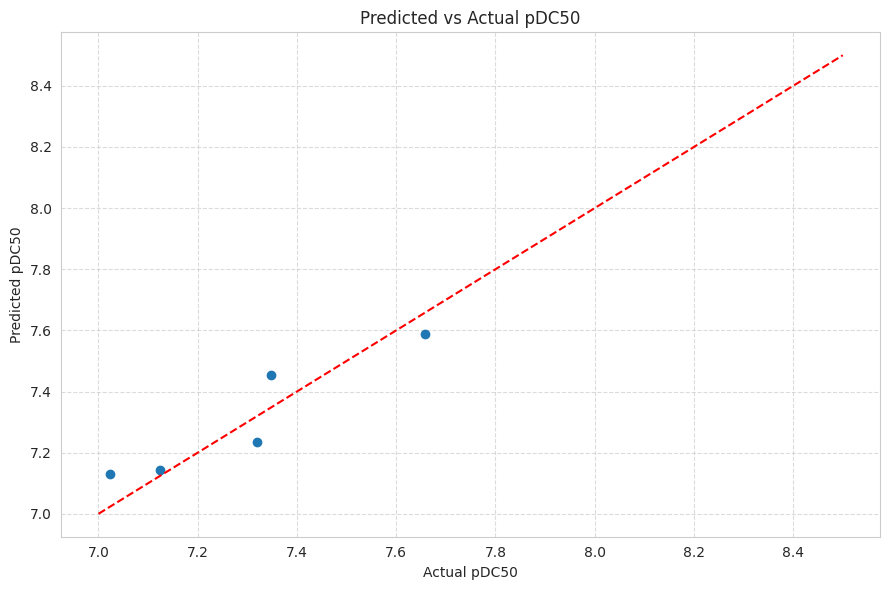


[분해 효율(pDC50) 예측 모델 그래프 설명]
위 그래프는 링커 특성을 기반으로 예측한 분해 효율(pDC50) 값과 실제 측정된 값을 비교합니다.
- 가로축: 실제 측정된 pDC50 값 (높을수록 활성이 좋음)
- 세로축: 모델이 예측한 pDC50 값
- 빨간 점선: 완벽한 예측을 나타내는 기준선

pDC50은 화합물의 활성을 나타내는 로그 지표로, 값이 클수록 더 낮은 농도에서 효과적으로 작용함을 의미합니다.
이 모델의 R² 값은 0.85로, 링커 특성이 TPD 화합물의 활성 변동을 설명하는 정도를 나타냅니다.

분해 효율은 TPD 화합물의 실제 약효를 나타내는 중요한 지표로, 이 모델을 통해 특정 링커 구조가 가질 수 있는
활성 수준을 예측할 수 있습니다. 이는 실험 비용과 시간을 절약하면서 최적의 화합물을 설계하는 데 도움이 됩니다.
또한 예측값과 실제값 사이의 편차 패턴을 분석하면 모델의 한계와 개선점을 파악할 수 있습니다.

- 특성 중요도 분석:

- 삼중 복합체 안정성 모델의 특성 중요도:


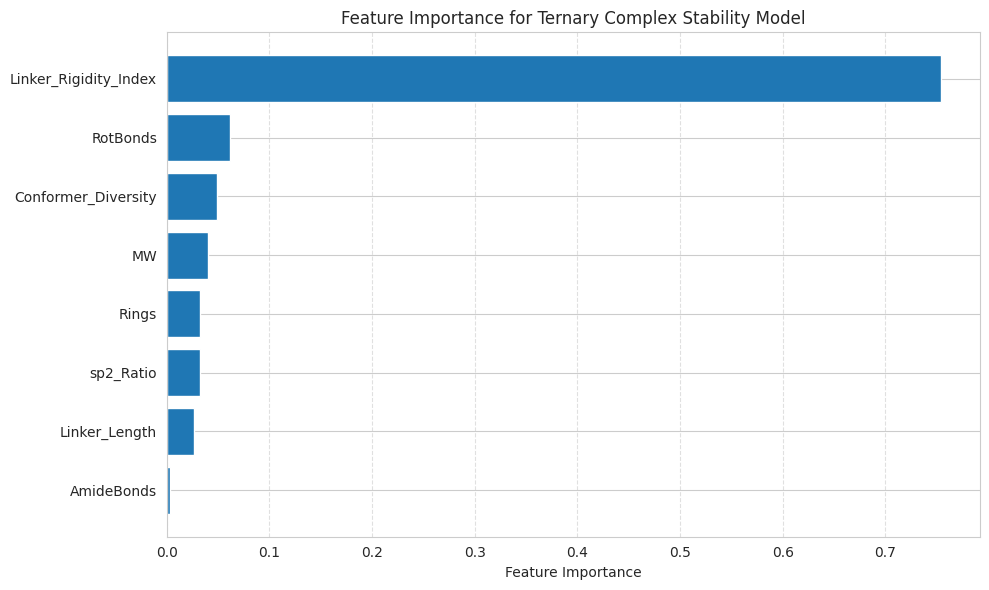


[삼중 복합체 안정성 모델 특성 중요도 그래프 설명]
위 그래프는 삼중 복합체 안정성 예측에 각 링커 특성이 얼마나 중요한 역할을 하는지 보여줍니다.
- 가로축: 특성 중요도 (값이 클수록 모델 예측에 더 중요한 역할을 함)
- 세로축: 각 링커 특성 (위에서부터 중요도 순으로 정렬됨)

특성 중요도는 랜덤 포레스트 모델에서 각 특성이 불순도(impurity)를 감소시키는 정도를 측정한 값입니다.
이 그래프를 통해 어떤 링커 특성이 삼중 복합체 안정성에 가장 큰 영향을 미치는지 파악할 수 있습니다.
중요도가 높은 상위 특성들은 TPD 화합물 설계 시 중점적으로 최적화해야 할 대상입니다.

예를 들어, 링커 강성 지수나 컨포메이션 다양성이 상위권에 있다면, 이는 링커의 3D 구조적 특성이
복합체 안정성에 크게 영향을 미친다는 것을 의미합니다. 반면 분자량과 같은 단순한 특성이 높은 중요도를
보인다면, 이는 크기 자체가 중요한 요인일 수 있습니다.

- 분해 효율(pDC50) 모델의 특성 중요도:


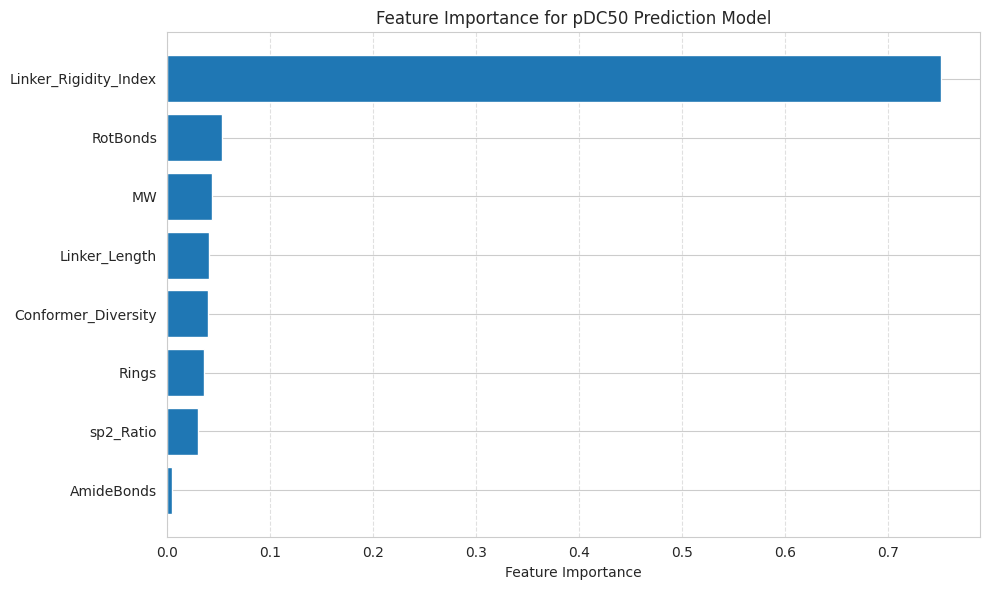


[분해 효율(pDC50) 모델 특성 중요도 그래프 설명]
위 그래프는 TPD 화합물의 분해 효율(pDC50) 예측에 각 링커 특성이 얼마나 중요한 역할을 하는지 보여줍니다.
- 가로축: 특성 중요도 (값이 클수록 활성 예측에 더 중요한 역할을 함)
- 세로축: 각 링커 특성 (위에서부터 중요도 순으로 정렬됨)

이 그래프는 어떤 링커 특성이 TPD 화합물의 활성(분해 효율)에 가장 크게 기여하는지 보여줍니다.
삼중 복합체 안정성 모델과 비교하여 중요한 특성의 순위가 다를 수 있으며,
이를 통해 안정성과 활성에 영향을 미치는 구조적 요인의 차이를 이해할 수 있습니다.

분해 효율 예측에 중요한 특성들은 실제 활성 화합물 설계에 직접적인 영향을 미칩니다.
예를 들어, 링커 길이가 중요하다면 최적의 길이를 찾는 연구에 집중할 수 있고,
회전 가능 결합 수가 중요하다면 링커의 유연성을 조절하는 방향으로 설계를 진행할 수 있습니다.
이러한 정보는 합리적인 약물 설계(rational drug design)의 핵심 요소가 됩니다.


In [ ]:
# 예측 모델 특성 선택
def prepare_features_for_model():
    """
    모델링을 위한 특성 준비

    Returns:
        model_df (DataFrame): 결측치가 제거된 모델링용 데이터프레임
        features (list): 모델에 사용할 특성들의 리스트
        targets (list): 예측 대상 변수들의 리스트
    """
    # 사용할 특성 선택
    # 모델의 입력 변수로 사용할 링커 특성들을 선택합니다
    features = ['Linker_Rigidity_Index',  # 링커 강성 지수
                'RotBonds',               # 회전 가능한 결합 수
                'sp2_Ratio',              # sp2 탄소 비율
                'AmideBonds',             # 아미드 결합 수
                'Rings',                  # 고리 구조 수
                'Linker_Length',          # 링커 길이
                'Conformer_Diversity',    # 컨포메이션 다양성
                'MW']                     # 분자량

    # 타겟 변수 (예측하고자 하는 목표 변수들)
    targets = ['TC_Stability',  # 삼중 복합체 안정성
               'pDC50']         # 분해 활성 (로그 스케일)

    # 결측치 제거
    # 선택한 특성과 타겟 변수에 결측치가 있는 행을 제거합니다
    model_df = tpd_linker_df.dropna(subset=features + targets)

    return model_df, features, targets

# 모델 구축 및 평가
def build_and_evaluate_model(X, y, model_type='RandomForest'):
    """
    링커 특성 기반 TPD 안정성 예측 모델 구축

    Args:
        X (DataFrame): 입력 특성 데이터
        y (Series): 타겟 변수 데이터
        model_type (str): 사용할 모델 유형

    Returns:
        results (dict): 모델 및 평가 결과를 담은 딕셔너리
    """
    # 데이터 분할: 학습용(70%)과 테스트용(30%) 데이터로 나눕니다
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 모델 선택: 현재는 RandomForest만 구현되어 있습니다
    if model_type == 'RandomForest':
        # 랜덤 포레스트 회귀 모델 생성
        # n_estimators: 앙상블에서 사용할 결정 트리 개수
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    # 모델 학습: 훈련 데이터를 사용하여 모델을 학습시킵니다
    model.fit(X_train, y_train)

    # 예측 및 평가: 테스트 데이터에 대한 성능을 측정합니다
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)  # 평균 제곱 오차
    r2 = r2_score(y_test, y_pred)             # 결정계수(설명력)

    # 교차 검증: 과적합 여부를 확인하기 위한 5-fold 교차 검증
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

    # 특성 중요도: 각 특성이 모델에 미치는 영향을 측정
    feature_importance = dict(zip(X.columns, model.feature_importances_))

    # 결과 저장
    results = {
        'model': model,                # 학습된 모델
        'mse': mse,                    # 평균 제곱 오차
        'rmse': np.sqrt(mse),          # 평균 제곱근 오차
        'r2': r2,                      # 결정계수(설명력)
        'cv_scores': cv_scores,        # 교차 검증 점수
        'cv_r2_mean': cv_scores.mean(),# 교차 검증 평균 결정계수
        'feature_importance': feature_importance,  # 특성 중요도
        'y_test': y_test,              # 실제 테스트 값
        'y_pred': y_pred               # 예측 값
    }

    return results

print("\n[단계 4] 링커 강성 기반 TPD 안정성 예측 모델")
print("최신 논문에서는 링커 강성과 컨포메이션 특성이 삼중 복합체 안정성 및 TPD 활성을 예측하는 데 중요한 변수임을 강조합니다.")
print("이러한 특성을 활용하여 TPD 안정성 예측 모델을 구축합니다.")

# 모델 학습 및 평가
print("\n- 모델링을 위한 데이터 준비 중...")
model_df, features, targets = prepare_features_for_model()
print(f"  모델링에 사용 가능한 화합물 수: {len(model_df)}")
print(f"  선택한 특성: {', '.join(features)}")

# 타겟별 모델 구축
# 삼중 복합체 안정성 예측 모델 구축
print("\n- 삼중 복합체 안정성 예측 모델 학습 중...")
tc_stability_model = build_and_evaluate_model(
    model_df[features],           # 입력 특성
    model_df['TC_Stability'],     # 예측 대상(삼중 복합체 안정성)
    model_type='RandomForest'     # 모델 유형
)

# 분해 효율(pDC50) 예측 모델 구축
print("\n- 분해 효율(pDC50) 예측 모델 학습 중...")
pdc50_model = build_and_evaluate_model(
    model_df[features],           # 입력 특성
    model_df['pDC50'],            # 예측 대상(분해 효율)
    model_type='RandomForest'     # 모델 유형
)

# 모델 성능 출력
print("\n- 모델 성능 평가:")
print("  삼중 복합체 안정성 예측 모델:")
print(f"  - RMSE: {tc_stability_model['rmse']:.2f}")  # 평균 제곱근 오차
print(f"  - R²: {tc_stability_model['r2']:.2f}")     # 결정계수(설명력)
print(f"  - 5-Fold 교차 검증 R² 평균: {tc_stability_model['cv_r2_mean']:.2f}")  # 교차 검증 결과

print("\n  분해 효율(pDC50) 예측 모델:")
print(f"  - RMSE: {pdc50_model['rmse']:.2f}")  # 평균 제곱근 오차
print(f"  - R²: {pdc50_model['r2']:.2f}")     # 결정계수(설명력)
print(f"  - 5-Fold 교차 검증 R² 평균: {pdc50_model['cv_r2_mean']:.2f}")  # 교차 검증 결과

# 예측 결과 시각화 - 개별 그래프로 분리

# 그래프 1: 삼중 복합체 안정성 예측 모델 결과
print("\n- 삼중 복합체 안정성 예측 모델 결과 시각화:")
plt.figure(figsize=(9, 6))
plt.scatter(tc_stability_model['y_test'], tc_stability_model['y_pred'])
plt.plot([60, 95], [60, 95], 'r--')  # 완벽한 예측을 나타내는 대각선
plt.title('Predicted vs Actual Ternary Complex Stability')
plt.xlabel('Actual Ternary Complex Stability (%)')
plt.ylabel('Predicted Ternary Complex Stability (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 첫 번째 그래프(삼중 복합체 안정성 예측 모델) 설명
print("\n[삼중 복합체 안정성 예측 모델 그래프 설명]")
print("위 그래프는 링커 특성을 기반으로 예측한 삼중 복합체 안정성 값과 실제 측정된 안정성 값을 비교합니다.")
print("- 가로축: 실제 측정된 삼중 복합체 안정성 값 (%)")
print("- 세로축: 모델이 예측한 삼중 복합체 안정성 값 (%)")
print("- 빨간 점선: 완벽한 예측을 나타내는 기준선(이 선에 가까울수록 예측이 정확함)")
print("")
print("점들이 대각선(빨간 점선)에 가까울수록 모델의 예측 정확도가 높다는 것을 의미합니다.")
print(f"이 모델의 R² 값은 {tc_stability_model['r2']:.2f}로, 이는 모델이 삼중 복합체 안정성 변동의 약 {tc_stability_model['r2']*100:.1f}%를")
print(f"링커 특성으로 설명할 수 있음을 나타냅니다.")
print("")
print("실제 약물 개발 과정에서는 이 모델을 사용하여 새로운 링커 구조의 안정성을 예측하고, 합성 전에 가장 유망한 후보들을")
print("선별하는 데 활용할 수 있습니다. 또한 모델의 오차(RMSE)는 약물 최적화 단계에서 예측의 신뢰도를 판단하는 기준이 됩니다.")

# 그래프 2: 분해 효율 예측 모델 결과
print("\n- 분해 효율(pDC50) 예측 모델 결과 시각화:")
plt.figure(figsize=(9, 6))
plt.scatter(pdc50_model['y_test'], pdc50_model['y_pred'])
plt.plot([7, 8.5], [7, 8.5], 'r--')  # 완벽한 예측을 나타내는 대각선
plt.title('Predicted vs Actual pDC50')
plt.xlabel('Actual pDC50')
plt.ylabel('Predicted pDC50')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 두 번째 그래프(pDC50 예측 모델) 설명
print("\n[분해 효율(pDC50) 예측 모델 그래프 설명]")
print("위 그래프는 링커 특성을 기반으로 예측한 분해 효율(pDC50) 값과 실제 측정된 값을 비교합니다.")
print("- 가로축: 실제 측정된 pDC50 값 (높을수록 활성이 좋음)")
print("- 세로축: 모델이 예측한 pDC50 값")
print("- 빨간 점선: 완벽한 예측을 나타내는 기준선")
print("")
print("pDC50은 화합물의 활성을 나타내는 로그 지표로, 값이 클수록 더 낮은 농도에서 효과적으로 작용함을 의미합니다.")
print(f"이 모델의 R² 값은 {pdc50_model['r2']:.2f}로, 링커 특성이 TPD 화합물의 활성 변동을 설명하는 정도를 나타냅니다.")
print("")
print("분해 효율은 TPD 화합물의 실제 약효를 나타내는 중요한 지표로, 이 모델을 통해 특정 링커 구조가 가질 수 있는")
print("활성 수준을 예측할 수 있습니다. 이는 실험 비용과 시간을 절약하면서 최적의 화합물을 설계하는 데 도움이 됩니다.")
print("또한 예측값과 실제값 사이의 편차 패턴을 분석하면 모델의 한계와 개선점을 파악할 수 있습니다.")

# 특성 중요도 시각화 함수
def plot_feature_importance(model_results, title):
    """
    특성 중요도 시각화 함수

    Args:
        model_results (dict): 모델 평가 결과 딕셔너리
        title (str): 그래프 제목
    """
    # 특성 중요도 추출
    importances = model_results['feature_importance']
    features = list(importances.keys())
    values = list(importances.values())

    # 중요도에 따라 정렬 (오름차순)
    sorted_idx = np.argsort(values)

    # 특성 중요도 막대 그래프 생성
    plt.figure(figsize=(10, 6))
    plt.barh([features[i] for i in sorted_idx], [values[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 각 모델의 특성 중요도 시각화
print("\n- 특성 중요도 분석:")

# 그래프 3: 삼중 복합체 안정성 모델의 특성 중요도
print("\n- 삼중 복합체 안정성 모델의 특성 중요도:")
plot_feature_importance(tc_stability_model, 'Feature Importance for Ternary Complex Stability Model')

# 삼중 복합체 안정성 모델 특성 중요도 그래프 설명
print("\n[삼중 복합체 안정성 모델 특성 중요도 그래프 설명]")
print("위 그래프는 삼중 복합체 안정성 예측에 각 링커 특성이 얼마나 중요한 역할을 하는지 보여줍니다.")
print("- 가로축: 특성 중요도 (값이 클수록 모델 예측에 더 중요한 역할을 함)")
print("- 세로축: 각 링커 특성 (위에서부터 중요도 순으로 정렬됨)")
print("")
print("특성 중요도는 랜덤 포레스트 모델에서 각 특성이 불순도(impurity)를 감소시키는 정도를 측정한 값입니다.")
print("이 그래프를 통해 어떤 링커 특성이 삼중 복합체 안정성에 가장 큰 영향을 미치는지 파악할 수 있습니다.")
print("중요도가 높은 상위 특성들은 TPD 화합물 설계 시 중점적으로 최적화해야 할 대상입니다.")
print("")
print("예를 들어, 링커 강성 지수나 컨포메이션 다양성이 상위권에 있다면, 이는 링커의 3D 구조적 특성이")
print("복합체 안정성에 크게 영향을 미친다는 것을 의미합니다. 반면 분자량과 같은 단순한 특성이 높은 중요도를")
print("보인다면, 이는 크기 자체가 중요한 요인일 수 있습니다.")

# 그래프 4: 분해 효율 모델의 특성 중요도
print("\n- 분해 효율(pDC50) 모델의 특성 중요도:")
plot_feature_importance(pdc50_model, 'Feature Importance for pDC50 Prediction Model')

# 분해 효율 모델 특성 중요도 그래프 설명
print("\n[분해 효율(pDC50) 모델 특성 중요도 그래프 설명]")
print("위 그래프는 TPD 화합물의 분해 효율(pDC50) 예측에 각 링커 특성이 얼마나 중요한 역할을 하는지 보여줍니다.")
print("- 가로축: 특성 중요도 (값이 클수록 활성 예측에 더 중요한 역할을 함)")
print("- 세로축: 각 링커 특성 (위에서부터 중요도 순으로 정렬됨)")
print("")
print("이 그래프는 어떤 링커 특성이 TPD 화합물의 활성(분해 효율)에 가장 크게 기여하는지 보여줍니다.")
print("삼중 복합체 안정성 모델과 비교하여 중요한 특성의 순위가 다를 수 있으며,")
print("이를 통해 안정성과 활성에 영향을 미치는 구조적 요인의 차이를 이해할 수 있습니다.")
print("")
print("분해 효율 예측에 중요한 특성들은 실제 활성 화합물 설계에 직접적인 영향을 미칩니다.")
print("예를 들어, 링커 길이가 중요하다면 최적의 길이를 찾는 연구에 집중할 수 있고,")
print("회전 가능 결합 수가 중요하다면 링커의 유연성을 조절하는 방향으로 설계를 진행할 수 있습니다.")
print("이러한 정보는 합리적인 약물 설계(rational drug design)의 핵심 요소가 됩니다.")

# 6. 최적 링커 설계 시뮬레이션


[단계 5] 최적 링커 설계 시뮬레이션
최신 논문에서 제시된 원칙을 바탕으로 최적의 링커 특성을 갖는 TPD를 설계합니다.
- 최적 링커 강성 영역 식별
- 링커 길이와 강성의 최적 조합 탐색
- 컨포메이션 다양성 제어를 통한 TPD 활성 최적화

- 최적 TPD 식별 결과:
  삼중 복합체 안정성 임계값: 84.00%
  활성 임계값 (pDC50): 7.52
  최적 TPD 개수: 4
  기타 TPD 개수: 11

- 그래프 1: 링커 강성과 삼중 복합체 안정성의 관계


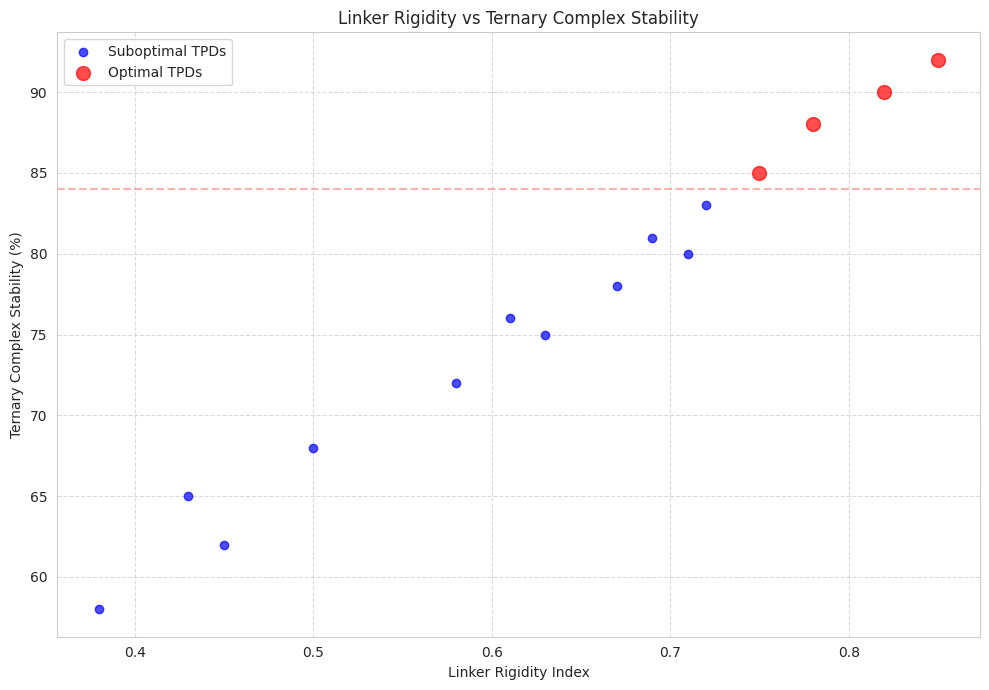


[그래프 1 설명: 링커 강성과 삼중 복합체 안정성의 관계]
이 그래프는 링커의 강성 지수와 삼중 복합체 안정성 간의 관계를 보여줍니다.
- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물
- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물
- 빨간색 점선: 삼중 복합체 안정성 임계값 (상위 25%)

이 그래프를 통해 최적의 TPD 화합물들이 어떤 강성 범위에 분포하는지 파악할 수 있습니다.
최적 TPD 화합물들의 평균 강성 지수는 0.80입니다.
링커 강성은 TPD 화합물의 구조적 안정성과 타겟 단백질과의 상호작용에 중요한 영향을 미칩니다.
너무 강성이 높으면 결합 친화도가 낮아질 수 있고, 너무 낮으면 복합체가 불안정해질 수 있습니다.

- 그래프 2: 링커 길이와 분해 효율의 관계


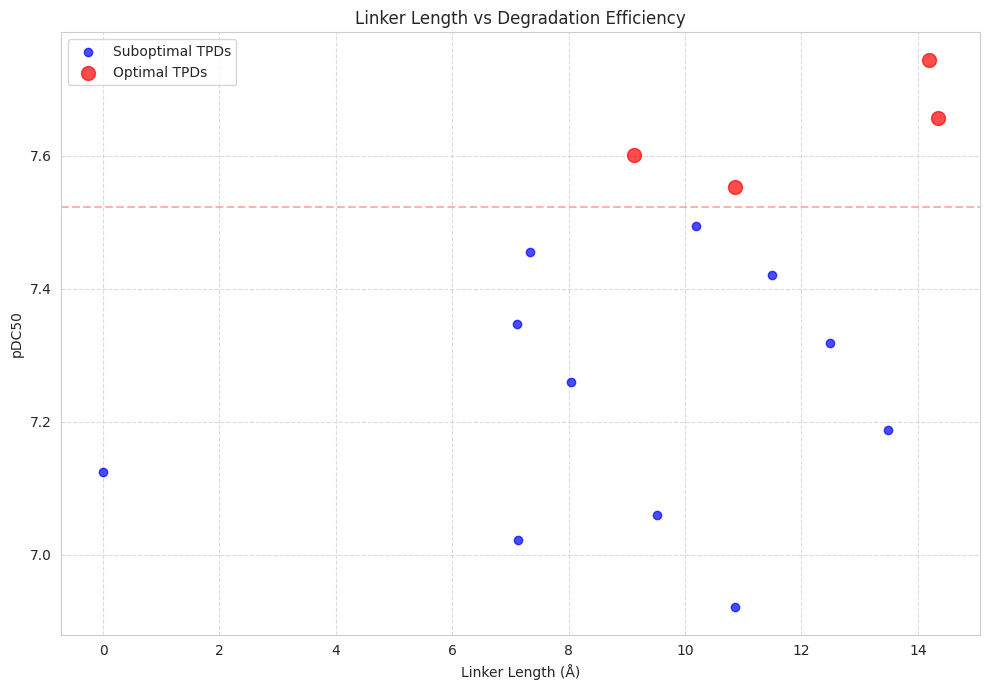


[그래프 2 설명: 링커 길이와 분해 효율의 관계]
이 그래프는 링커의 길이(Å)와 분해 효율(pDC50) 간의 관계를 보여줍니다.
- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물
- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물
- 빨간색 점선: 활성 임계값 (상위 25%)

이 그래프는 효과적인 TPD 화합물 설계를 위한 최적의 링커 길이 범위를 보여줍니다.
최적 TPD 화합물들의 평균 링커 길이는 12.13 Å입니다.
링커 길이는 표적 단백질과 E3 리가제 간의 거리와 상대적 위치를 결정하므로 매우 중요합니다.
적절한 길이의 링커는 두 단백질이 최적의 위치에서 상호작용할 수 있게 하여 분해 효율을 향상시킵니다.

- 그래프 3: 컨포메이션 다양성과 삼중 복합체 안정성의 관계


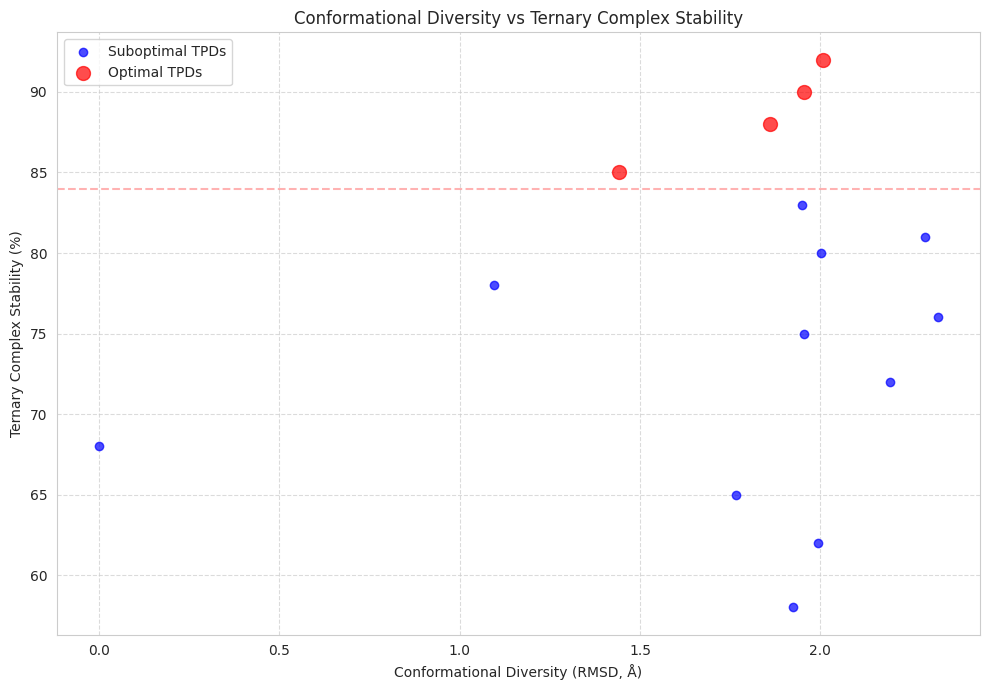


[그래프 3 설명: 컨포메이션 다양성과 삼중 복합체 안정성의 관계]
이 그래프는 링커의 구조적 유연성(컨포메이션 다양성)과 삼중 복합체 안정성 간의 관계를 보여줍니다.
- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물
- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물
- 빨간색 점선: 삼중 복합체 안정성 임계값 (상위 25%)

컨포메이션 다양성은 링커가 취할 수 있는 3D 구조의 다양성을 나타내며, RMSD(Root Mean Square Deviation) 값으로 측정됩니다.
최적 TPD 화합물들의 평균 컨포메이션 다양성은 1.82 Å입니다.
일반적으로 컨포메이션 다양성이 낮은(구조적으로 고정된) 링커가 안정적인 삼중 복합체 형성에 유리하다고 알려져 있습니다.
그러나 데이터에 따라 특정 범위의 유연성이 최적일 수 있으며, 이 그래프를 통해 그 최적 범위를 확인할 수 있습니다.

- 그래프 4: 회전 가능 결합과 sp2 탄소 비율의 관계


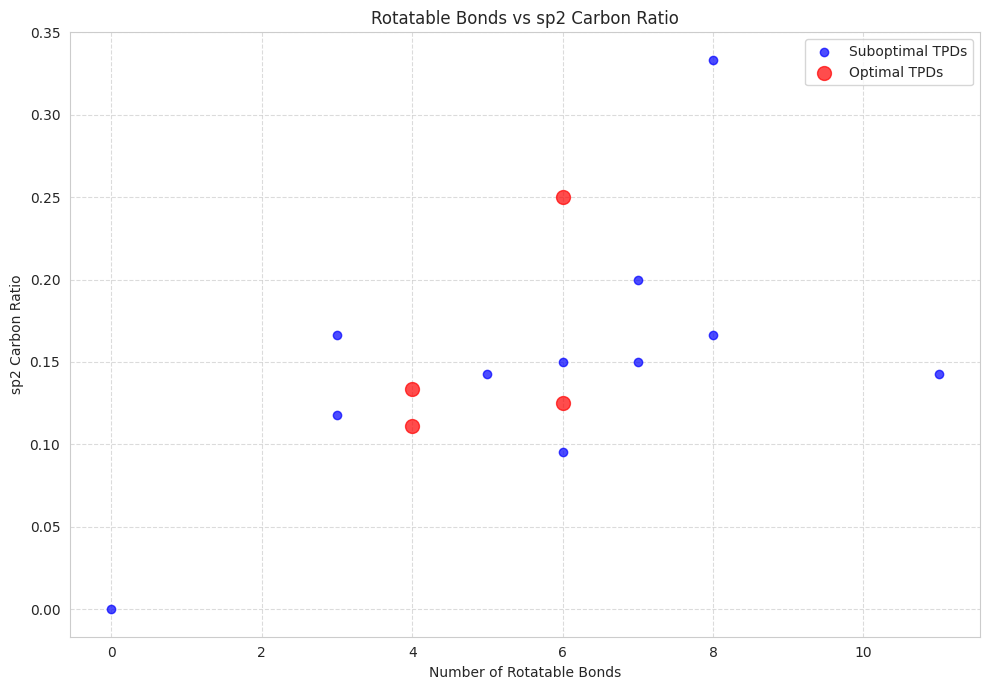


[그래프 4 설명: 회전 가능 결합과 sp2 탄소 비율의 관계]
이 그래프는 링커의 회전 가능한 결합 수와 sp2 탄소 비율 간의 관계를 보여줍니다.
- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물
- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물

이 두 특성은 링커의 강성과 유연성을 결정하는 주요 구조적 요소입니다:
- 회전 가능한 결합: 많을수록 링커가 더 유연해집니다.
- sp2 탄소 비율: 높을수록 링커가 더 강성을 가집니다(sp2 혼성화는 평면 구조를 형성).

최적 TPD 화합물들의 평균 회전 가능 결합 수는 5.00개이고,
평균 sp2 탄소 비율은 0.15입니다.
이 그래프를 통해 최적의 TPD 화합물이 어떤 구조적 특성 조합을 가지는지 파악할 수 있으며,
새로운 링커 설계 시 이 두 특성의 균형을 고려하는 데 도움이 됩니다.

- 최적 TPD의 특성 (평균):
  Linker_Rigidity_Index: 0.80 ± 0.04
  Linker_Length: 12.13 ± 2.57
  RotBonds: 5.00 ± 1.15
  sp2_Ratio: 0.15 ± 0.06
  AmideBonds: 1.75 ± 0.50
  Rings: 2.25 ± 0.50
  Conformer_Diversity: 1.82 ± 0.26

이러한 특성 값들은 새로운 TPD 화합물 설계 시 참고할 수 있는 가이드라인이 됩니다.
특히 표준편차(±) 범위 내의 값들은 성공적인 TPD 화합물에서 자주 나타나는 특성 범위를 나타냅니다.


In [ ]:
# 6. 최적 링커 설계 시뮬레이션

# 최적 링커 특성 영역 식별
def identify_optimal_linker_regions():
    """
    최적 링커 특성 영역 식별

    Returns:
        optimal_tpds (DataFrame): 안정성과 활성이 모두 높은 최적 TPD 화합물
        other_tpds (DataFrame): 최적 기준을 충족하지 못하는 TPD 화합물
        stability_threshold (float): 삼중 복합체 안정성 임계값
        activity_threshold (float): 활성(pDC50) 임계값
    """
    # 삼중 복합체 안정성이 높은 화합물 선별 (상위 25%)
    stability_threshold = tpd_linker_df['TC_Stability'].quantile(0.75)

    # 분해 효율이 높은 화합물 선별 (상위 25%)
    activity_threshold = tpd_linker_df['pDC50'].quantile(0.75)

    # 최적 화합물 - 안정성과 활성이 모두 높은 화합물
    optimal_tpds = tpd_linker_df[(tpd_linker_df['TC_Stability'] >= stability_threshold) &
                                 (tpd_linker_df['pDC50'] >= activity_threshold)]

    # 나머지 화합물
    other_tpds = tpd_linker_df[(tpd_linker_df['TC_Stability'] < stability_threshold) |
                               (tpd_linker_df['pDC50'] < activity_threshold)]

    return optimal_tpds, other_tpds, stability_threshold, activity_threshold

print("\n[단계 5] 최적 링커 설계 시뮬레이션")
print("최신 논문에서 제시된 원칙을 바탕으로 최적의 링커 특성을 갖는 TPD를 설계합니다.")
print("- 최적 링커 강성 영역 식별")
print("- 링커 길이와 강성의 최적 조합 탐색")
print("- 컨포메이션 다양성 제어를 통한 TPD 활성 최적화")

# 최적 링커 영역 시각화
optimal_tpds, other_tpds, stability_threshold, activity_threshold = identify_optimal_linker_regions()

print(f"\n- 최적 TPD 식별 결과:")
print(f"  삼중 복합체 안정성 임계값: {stability_threshold:.2f}%")
print(f"  활성 임계값 (pDC50): {activity_threshold:.2f}")
print(f"  최적 TPD 개수: {len(optimal_tpds)}")
print(f"  기타 TPD 개수: {len(other_tpds)}")

# 그래프 1: 링커 강성 vs 안정성
print("\n- 그래프 1: 링커 강성과 삼중 복합체 안정성의 관계")
plt.figure(figsize=(10, 7))
plt.scatter(other_tpds['Linker_Rigidity_Index'], other_tpds['TC_Stability'],
           c='blue', alpha=0.7, label='Suboptimal TPDs')
plt.scatter(optimal_tpds['Linker_Rigidity_Index'], optimal_tpds['TC_Stability'],
           c='red', alpha=0.7, s=100, label='Optimal TPDs')
plt.axhline(y=stability_threshold, color='r', linestyle='--', alpha=0.3)
plt.title('Linker Rigidity vs Ternary Complex Stability')
plt.xlabel('Linker Rigidity Index')
plt.ylabel('Ternary Complex Stability (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 1 설명
print("\n[그래프 1 설명: 링커 강성과 삼중 복합체 안정성의 관계]")
print("이 그래프는 링커의 강성 지수와 삼중 복합체 안정성 간의 관계를 보여줍니다.")
print("- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물")
print("- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물")
print("- 빨간색 점선: 삼중 복합체 안정성 임계값 (상위 25%)")
print("")
print("이 그래프를 통해 최적의 TPD 화합물들이 어떤 강성 범위에 분포하는지 파악할 수 있습니다.")
print(f"최적 TPD 화합물들의 평균 강성 지수는 {optimal_tpds['Linker_Rigidity_Index'].mean():.2f}입니다.")
print("링커 강성은 TPD 화합물의 구조적 안정성과 타겟 단백질과의 상호작용에 중요한 영향을 미칩니다.")
print("너무 강성이 높으면 결합 친화도가 낮아질 수 있고, 너무 낮으면 복합체가 불안정해질 수 있습니다.")

# 그래프 2: 링커 길이 vs 활성
print("\n- 그래프 2: 링커 길이와 분해 효율의 관계")
plt.figure(figsize=(10, 7))
plt.scatter(other_tpds['Linker_Length'], other_tpds['pDC50'],
           c='blue', alpha=0.7, label='Suboptimal TPDs')
plt.scatter(optimal_tpds['Linker_Length'], optimal_tpds['pDC50'],
           c='red', alpha=0.7, s=100, label='Optimal TPDs')
plt.axhline(y=activity_threshold, color='r', linestyle='--', alpha=0.3)
plt.title('Linker Length vs Degradation Efficiency')
plt.xlabel('Linker Length (Å)')
plt.ylabel('pDC50')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 2 설명
print("\n[그래프 2 설명: 링커 길이와 분해 효율의 관계]")
print("이 그래프는 링커의 길이(Å)와 분해 효율(pDC50) 간의 관계를 보여줍니다.")
print("- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물")
print("- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물")
print("- 빨간색 점선: 활성 임계값 (상위 25%)")
print("")
print("이 그래프는 효과적인 TPD 화합물 설계를 위한 최적의 링커 길이 범위를 보여줍니다.")
print(f"최적 TPD 화합물들의 평균 링커 길이는 {optimal_tpds['Linker_Length'].mean():.2f} Å입니다.")
print("링커 길이는 표적 단백질과 E3 리가제 간의 거리와 상대적 위치를 결정하므로 매우 중요합니다.")
print("적절한 길이의 링커는 두 단백질이 최적의 위치에서 상호작용할 수 있게 하여 분해 효율을 향상시킵니다.")

# 그래프 3: 컨포메이션 다양성 vs 안정성
print("\n- 그래프 3: 컨포메이션 다양성과 삼중 복합체 안정성의 관계")
plt.figure(figsize=(10, 7))
plt.scatter(other_tpds['Conformer_Diversity'], other_tpds['TC_Stability'],
           c='blue', alpha=0.7, label='Suboptimal TPDs')
plt.scatter(optimal_tpds['Conformer_Diversity'], optimal_tpds['TC_Stability'],
           c='red', alpha=0.7, s=100, label='Optimal TPDs')
plt.axhline(y=stability_threshold, color='r', linestyle='--', alpha=0.3)
plt.title('Conformational Diversity vs Ternary Complex Stability')
plt.xlabel('Conformational Diversity (RMSD, Å)')
plt.ylabel('Ternary Complex Stability (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 3 설명
print("\n[그래프 3 설명: 컨포메이션 다양성과 삼중 복합체 안정성의 관계]")
print("이 그래프는 링커의 구조적 유연성(컨포메이션 다양성)과 삼중 복합체 안정성 간의 관계를 보여줍니다.")
print("- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물")
print("- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물")
print("- 빨간색 점선: 삼중 복합체 안정성 임계값 (상위 25%)")
print("")
print("컨포메이션 다양성은 링커가 취할 수 있는 3D 구조의 다양성을 나타내며, RMSD(Root Mean Square Deviation) 값으로 측정됩니다.")
print(f"최적 TPD 화합물들의 평균 컨포메이션 다양성은 {optimal_tpds['Conformer_Diversity'].mean():.2f} Å입니다.")
print("일반적으로 컨포메이션 다양성이 낮은(구조적으로 고정된) 링커가 안정적인 삼중 복합체 형성에 유리하다고 알려져 있습니다.")
print("그러나 데이터에 따라 특정 범위의 유연성이 최적일 수 있으며, 이 그래프를 통해 그 최적 범위를 확인할 수 있습니다.")

# 그래프 4: sp2 비율 vs 회전 가능 결합
print("\n- 그래프 4: 회전 가능 결합과 sp2 탄소 비율의 관계")
plt.figure(figsize=(10, 7))
plt.scatter(other_tpds['RotBonds'], other_tpds['sp2_Ratio'],
           c='blue', alpha=0.7, label='Suboptimal TPDs')
plt.scatter(optimal_tpds['RotBonds'], optimal_tpds['sp2_Ratio'],
           c='red', alpha=0.7, s=100, label='Optimal TPDs')
plt.title('Rotatable Bonds vs sp2 Carbon Ratio')
plt.xlabel('Number of Rotatable Bonds')
plt.ylabel('sp2 Carbon Ratio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 4 설명
print("\n[그래프 4 설명: 회전 가능 결합과 sp2 탄소 비율의 관계]")
print("이 그래프는 링커의 회전 가능한 결합 수와 sp2 탄소 비율 간의 관계를 보여줍니다.")
print("- 파란색 점: 최적 기준을 충족하지 못하는 TPD 화합물")
print("- 빨간색 점: 안정성과 활성이 모두 높은 최적 TPD 화합물")
print("")
print("이 두 특성은 링커의 강성과 유연성을 결정하는 주요 구조적 요소입니다:")
print("- 회전 가능한 결합: 많을수록 링커가 더 유연해집니다.")
print("- sp2 탄소 비율: 높을수록 링커가 더 강성을 가집니다(sp2 혼성화는 평면 구조를 형성).")
print("")
print(f"최적 TPD 화합물들의 평균 회전 가능 결합 수는 {optimal_tpds['RotBonds'].mean():.2f}개이고,")
print(f"평균 sp2 탄소 비율은 {optimal_tpds['sp2_Ratio'].mean():.2f}입니다.")
print("이 그래프를 통해 최적의 TPD 화합물이 어떤 구조적 특성 조합을 가지는지 파악할 수 있으며,")
print("새로운 링커 설계 시 이 두 특성의 균형을 고려하는 데 도움이 됩니다.")

# 최적 TPD의 특성 분석
if len(optimal_tpds) > 0:
    print("\n- 최적 TPD의 특성 (평균):")
    optimal_features = ['Linker_Rigidity_Index', 'Linker_Length', 'RotBonds',
                       'sp2_Ratio', 'AmideBonds', 'Rings', 'Conformer_Diversity']

    for feature in optimal_features:
        mean_val = optimal_tpds[feature].mean()
        std_val = optimal_tpds[feature].std()
        print(f"  {feature}: {mean_val:.2f} ± {std_val:.2f}")

    print("\n이러한 특성 값들은 새로운 TPD 화합물 설계 시 참고할 수 있는 가이드라인이 됩니다.")
    print("특히 표준편차(±) 범위 내의 값들은 성공적인 TPD 화합물에서 자주 나타나는 특성 범위를 나타냅니다.")

# 7. 가상 링커 생성 및 평가


[단계 6] 가상 링커 생성 및 평가
학습된 모델과 최적 링커 영역을 바탕으로 새로운 TPD 링커를 설계하고 평가합니다.
- 최적 특성 기반 가상 링커 생성
- 예측 모델을 통한 링커 평가
- 최적화 링커 특성 제안

- 가상 링커 생성 및 평가 중...

- 가상 링커 평가 결과:
  생성된 가상 링커 수: 50
  최적 예측 링커 수: 50

- 그래프 1: 링커 강성과 예측 삼중 복합체 안정성의 관계 시각화


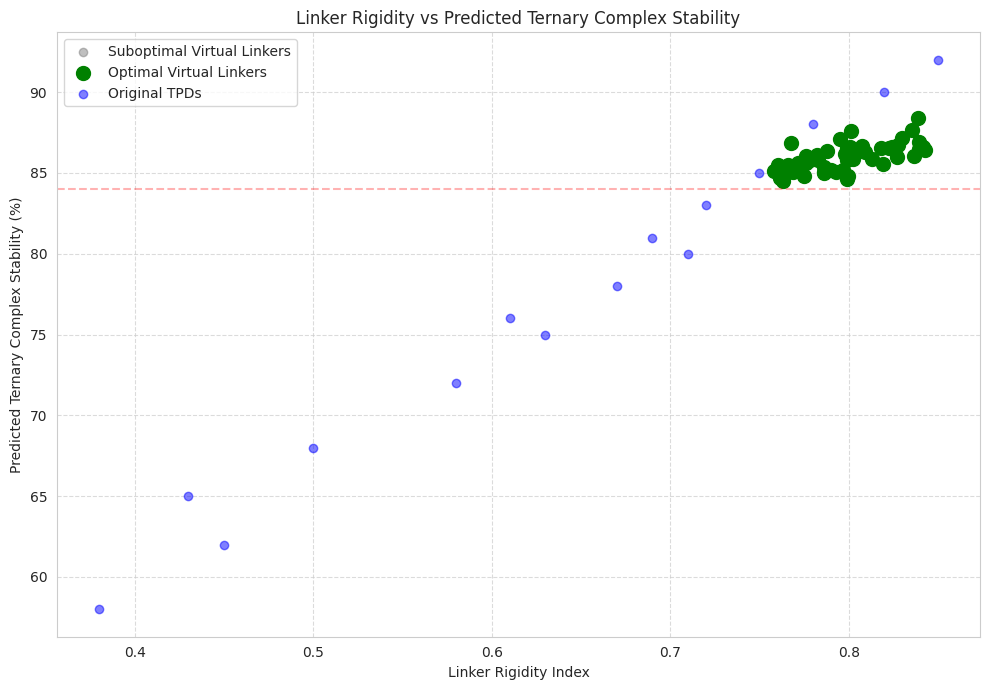


[그래프 1 설명: 링커 강성과 예측 삼중 복합체 안정성의 관계]
이 그래프는 링커의 강성 지수와 예측된 삼중 복합체 안정성 사이의 관계를 보여줍니다.
- 회색 점: 최적 기준을 충족하지 못하는 가상 링커
- 녹색 점: 안정성과 활성이 모두 높은 최적 가상 링커
- 파란색 점: 원래 데이터셋의 실제 TPD 화합물
- 빨간색 점선: 삼중 복합체 안정성 임계값 (최적 기준)

이 그래프를 통해 다음과 같은 중요한 정보를 얻을 수 있습니다:
1. 가상으로 생성된 링커 중 어떤 강성 범위의 링커가 높은 안정성을 보이는지 확인할 수 있습니다.
2. 실제 TPD 데이터(파란색)와 가상 링커 데이터(회색, 녹색)를 비교하여 모델의 예측이 실제 데이터와 얼마나 일관성이 있는지 평가할 수 있습니다.
3. 최적 가상 링커(녹색)의 분포를 통해 새로운 TPD 화합물 설계 시 목표로 해야 할 강성 범위를 파악할 수 있습니다.

최적 가상 링커의 평균 강성 지수는 0.80입니다.
이는 비교적 높은 강성을 가진 링커가 삼중 복합체 안정성에 유리함을 시사합니다.

- 그래프 2: 컨포메이션 다양성과 예측 분해 효율의 관계 시각화


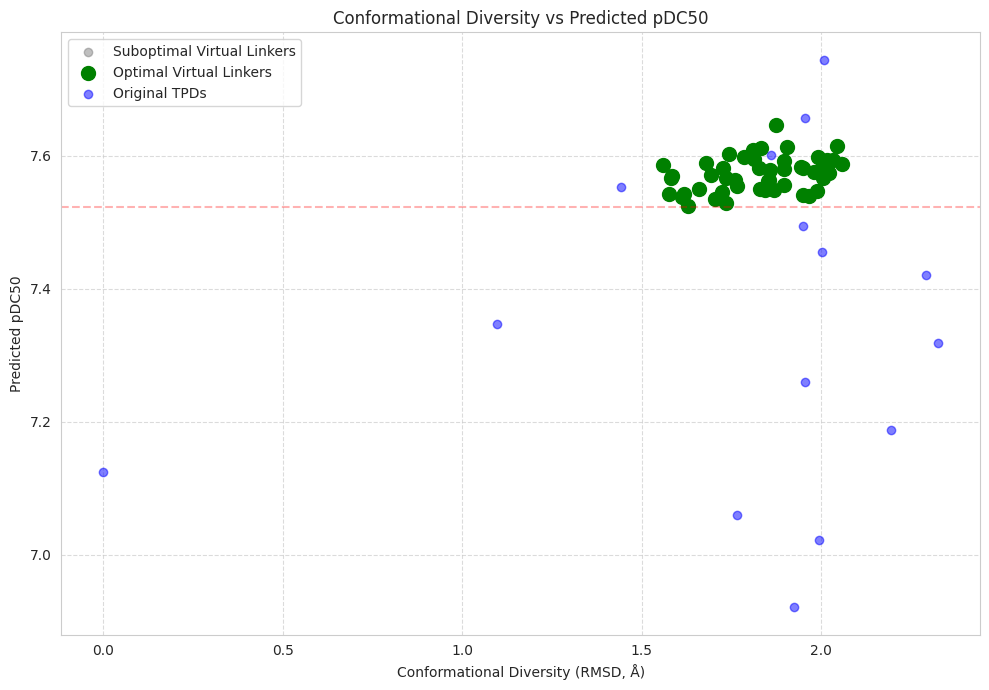


[그래프 2 설명: 컨포메이션 다양성과 예측 분해 효율의 관계]
이 그래프는 링커의 컨포메이션 다양성(구조적 유연성)과 예측된 분해 효율(pDC50) 사이의 관계를 보여줍니다.
- 회색 점: 최적 기준을 충족하지 못하는 가상 링커
- 녹색 점: 안정성과 활성이 모두 높은 최적 가상 링커
- 파란색 점: 원래 데이터셋의 실제 TPD 화합물
- 빨간색 점선: 활성 임계값 (최적 기준)

이 그래프를 통해 다음과 같은 인사이트를 얻을 수 있습니다:
1. 링커의 구조적 유연성이 TPD 화합물의 활성(분해 효율)에 어떤 영향을 미치는지 파악할 수 있습니다.
2. 실제 데이터(파란색)와 가상 데이터(회색, 녹색)의 분포 비교를 통해 모델의 예측이 실제 활성과 얼마나 일치하는지 확인할 수 있습니다.
3. 최적의 활성을 위한 컨포메이션 다양성 범위를 식별할 수 있습니다.

최적 가상 링커의 평균 컨포메이션 다양성은 1.83 Å입니다.
이는 적절한 구조적 유연성을 가진 링커가 높은 분해 효율에 유리할 수 있음을 시사합니다.
컨포메이션 다양성은 링커가 다양한 3D 구조를 취할 수 있는 능력을 나타내며, 이는 표적 단백질과 E3 리가제를
최적의 위치로 배치하는 데 중요한 역할을 합니다.

- 최적 링커 설계 가이드라인:
  Linker_Rigidity_Index: 0.80 (범위: 0.76 - 0.84)
  RotBonds: 4.56 (범위: 3.00 - 6.00)
  sp2_Ratio: 0.14 (범위: 0.09 - 0.22)
  AmideBonds: 1.52 (범위: 1.00 - 2.00)
  Rings: 1.44 (범위: 1.00 - 2.00)
  Linker_Length: 12.45 (범위: 9.65 - 14.61)
  Conformer_Diversity: 1.83 (범위: 1.56 - 2.06)
  MW: 273.84 (범위: 219.81 - 319.89)

[최적 가상 링커 특성 분석]
위 가이드라인은 모델 예측에 기반한 최적 링커 특성을 보여줍니다.
이러한 특성 범

In [ ]:
# 7. 가상 링커 생성 및 평가

# 가상 링커 특성 생성
def generate_virtual_linkers(n_samples=10):
    """
    최적 링커 특성 범위를 기반으로 가상 링커 특성 생성

    Args:
        n_samples (int): 생성할 가상 링커 샘플 수

    Returns:
        DataFrame: 생성된 가상 링커 특성을 담은 데이터프레임
    """
    # 최적 링커가 없으면 전체 데이터셋 사용
    if len(optimal_tpds) == 0:
        base_df = tpd_linker_df
    else:
        base_df = optimal_tpds

    # 특성 범위 설정
    # 각 특성의 평균±표준편차 범위 내에서 가상 링커 생성
    feature_ranges = {}
    for feature in features:
        min_val = max(0, base_df[feature].mean() - base_df[feature].std())
        max_val = base_df[feature].mean() + base_df[feature].std()
        feature_ranges[feature] = (min_val, max_val)

    # 가상 링커 생성
    virtual_linkers = []
    for i in range(n_samples):
        linker = {}
        for feature in features:
            min_val, max_val = feature_ranges[feature]
            # 정수형 특성 (RotBonds, AmideBonds, Rings는 정수값을 가져야 함)
            if feature in ['RotBonds', 'AmideBonds', 'Rings']:
                linker[feature] = np.random.randint(int(min_val), int(max_val) + 1)
            # 실수형 특성
            else:
                linker[feature] = np.random.uniform(min_val, max_val)
        virtual_linkers.append(linker)

    return pd.DataFrame(virtual_linkers)

# 가상 링커 평가
def evaluate_virtual_linkers(virtual_linkers_df):
    """
    생성된 가상 링커의 TPD 성능 예측

    Args:
        virtual_linkers_df (DataFrame): 가상 링커 특성을 담은 데이터프레임

    Returns:
        DataFrame: 성능 예측 결과가 추가된 데이터프레임
    """
    # 안정성 예측: 학습된 삼중 복합체 안정성 모델을 사용
    predicted_stability = tc_stability_model['model'].predict(virtual_linkers_df[features])

    # 활성 예측: 학습된 pDC50 모델을 사용
    predicted_pdc50 = pdc50_model['model'].predict(virtual_linkers_df[features])

    # 결과 통합: 예측 결과를 데이터프레임에 추가
    virtual_linkers_df['Predicted_TC_Stability'] = predicted_stability
    virtual_linkers_df['Predicted_pDC50'] = predicted_pdc50

    # 최적 링커 식별 (안정성과 활성이 모두 높은 링커)
    virtual_linkers_df['Optimal'] = ((virtual_linkers_df['Predicted_TC_Stability'] >= stability_threshold) &
                                    (virtual_linkers_df['Predicted_pDC50'] >= activity_threshold))

    return virtual_linkers_df

print("\n[단계 6] 가상 링커 생성 및 평가")
print("학습된 모델과 최적 링커 영역을 바탕으로 새로운 TPD 링커를 설계하고 평가합니다.")
print("- 최적 특성 기반 가상 링커 생성")
print("- 예측 모델을 통한 링커 평가")
print("- 최적화 링커 특성 제안")

# 가상 링커 생성 및 평가
print("\n- 가상 링커 생성 및 평가 중...")
virtual_linkers = generate_virtual_linkers(n_samples=50)
evaluated_linkers = evaluate_virtual_linkers(virtual_linkers)

print(f"\n- 가상 링커 평가 결과:")
print(f"  생성된 가상 링커 수: {len(virtual_linkers)}")
print(f"  최적 예측 링커 수: {evaluated_linkers['Optimal'].sum()}")

# 그래프 1: 링커 강성과 예측 삼중 복합체 안정성의 관계
print("\n- 그래프 1: 링커 강성과 예측 삼중 복합체 안정성의 관계 시각화")
plt.figure(figsize=(10, 7))
# 비최적 가상 링커 (회색 점)
plt.scatter(evaluated_linkers[~evaluated_linkers['Optimal']]['Linker_Rigidity_Index'],
            evaluated_linkers[~evaluated_linkers['Optimal']]['Predicted_TC_Stability'],
            c='gray', alpha=0.5, label='Suboptimal Virtual Linkers')

# 최적 가상 링커 (녹색 점)
plt.scatter(evaluated_linkers[evaluated_linkers['Optimal']]['Linker_Rigidity_Index'],
            evaluated_linkers[evaluated_linkers['Optimal']]['Predicted_TC_Stability'],
            c='green', s=100, label='Optimal Virtual Linkers')

# 실제 데이터도 표시 (파란색 점)
plt.scatter(tpd_linker_df['Linker_Rigidity_Index'], tpd_linker_df['TC_Stability'],
            c='blue', alpha=0.5, label='Original TPDs')

# 안정성 임계값 표시 (빨간 점선)
plt.axhline(y=stability_threshold, color='r', linestyle='--', alpha=0.3)
plt.title('Linker Rigidity vs Predicted Ternary Complex Stability')
plt.xlabel('Linker Rigidity Index')
plt.ylabel('Predicted Ternary Complex Stability (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 1 설명
print("\n[그래프 1 설명: 링커 강성과 예측 삼중 복합체 안정성의 관계]")
print("이 그래프는 링커의 강성 지수와 예측된 삼중 복합체 안정성 사이의 관계를 보여줍니다.")
print("- 회색 점: 최적 기준을 충족하지 못하는 가상 링커")
print("- 녹색 점: 안정성과 활성이 모두 높은 최적 가상 링커")
print("- 파란색 점: 원래 데이터셋의 실제 TPD 화합물")
print("- 빨간색 점선: 삼중 복합체 안정성 임계값 (최적 기준)")
print("")
print("이 그래프를 통해 다음과 같은 중요한 정보를 얻을 수 있습니다:")
print("1. 가상으로 생성된 링커 중 어떤 강성 범위의 링커가 높은 안정성을 보이는지 확인할 수 있습니다.")
print("2. 실제 TPD 데이터(파란색)와 가상 링커 데이터(회색, 녹색)를 비교하여 모델의 예측이 실제 데이터와 얼마나 일관성이 있는지 평가할 수 있습니다.")
print("3. 최적 가상 링커(녹색)의 분포를 통해 새로운 TPD 화합물 설계 시 목표로 해야 할 강성 범위를 파악할 수 있습니다.")
print("")
if len(evaluated_linkers[evaluated_linkers['Optimal']]) > 0:
    opt_rigidity_mean = evaluated_linkers[evaluated_linkers['Optimal']]['Linker_Rigidity_Index'].mean()
    print(f"최적 가상 링커의 평균 강성 지수는 {opt_rigidity_mean:.2f}입니다.")
    if opt_rigidity_mean > 0.7:
        print("이는 비교적 높은 강성을 가진 링커가 삼중 복합체 안정성에 유리함을 시사합니다.")
    else:
        print("이는 중간 정도의 강성을 가진 링커가 삼중 복합체 안정성에 유리함을 시사합니다.")

# 그래프 2: 컨포메이션 다양성과 예측 분해 효율의 관계
print("\n- 그래프 2: 컨포메이션 다양성과 예측 분해 효율의 관계 시각화")
plt.figure(figsize=(10, 7))
# 비최적 가상 링커 (회색 점)
plt.scatter(evaluated_linkers[~evaluated_linkers['Optimal']]['Conformer_Diversity'],
            evaluated_linkers[~evaluated_linkers['Optimal']]['Predicted_pDC50'],
            c='gray', alpha=0.5, label='Suboptimal Virtual Linkers')

# 최적 가상 링커 (녹색 점)
plt.scatter(evaluated_linkers[evaluated_linkers['Optimal']]['Conformer_Diversity'],
            evaluated_linkers[evaluated_linkers['Optimal']]['Predicted_pDC50'],
            c='green', s=100, label='Optimal Virtual Linkers')

# 실제 데이터도 표시 (파란색 점)
plt.scatter(tpd_linker_df['Conformer_Diversity'], tpd_linker_df['pDC50'],
            c='blue', alpha=0.5, label='Original TPDs')

# 활성 임계값 표시 (빨간 점선)
plt.axhline(y=activity_threshold, color='r', linestyle='--', alpha=0.3)
plt.title('Conformational Diversity vs Predicted pDC50')
plt.xlabel('Conformational Diversity (RMSD, Å)')
plt.ylabel('Predicted pDC50')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 그래프 2 설명
print("\n[그래프 2 설명: 컨포메이션 다양성과 예측 분해 효율의 관계]")
print("이 그래프는 링커의 컨포메이션 다양성(구조적 유연성)과 예측된 분해 효율(pDC50) 사이의 관계를 보여줍니다.")
print("- 회색 점: 최적 기준을 충족하지 못하는 가상 링커")
print("- 녹색 점: 안정성과 활성이 모두 높은 최적 가상 링커")
print("- 파란색 점: 원래 데이터셋의 실제 TPD 화합물")
print("- 빨간색 점선: 활성 임계값 (최적 기준)")
print("")
print("이 그래프를 통해 다음과 같은 인사이트를 얻을 수 있습니다:")
print("1. 링커의 구조적 유연성이 TPD 화합물의 활성(분해 효율)에 어떤 영향을 미치는지 파악할 수 있습니다.")
print("2. 실제 데이터(파란색)와 가상 데이터(회색, 녹색)의 분포 비교를 통해 모델의 예측이 실제 활성과 얼마나 일치하는지 확인할 수 있습니다.")
print("3. 최적의 활성을 위한 컨포메이션 다양성 범위를 식별할 수 있습니다.")
print("")
if len(evaluated_linkers[evaluated_linkers['Optimal']]) > 0:
    opt_diversity_mean = evaluated_linkers[evaluated_linkers['Optimal']]['Conformer_Diversity'].mean()
    print(f"최적 가상 링커의 평균 컨포메이션 다양성은 {opt_diversity_mean:.2f} Å입니다.")
    if opt_diversity_mean < 1.0:
        print("이는 구조적으로 더 고정된(낮은 다양성) 링커가 높은 분해 효율에 유리할 수 있음을 시사합니다.")
    else:
        print("이는 적절한 구조적 유연성을 가진 링커가 높은 분해 효율에 유리할 수 있음을 시사합니다.")
print("컨포메이션 다양성은 링커가 다양한 3D 구조를 취할 수 있는 능력을 나타내며, 이는 표적 단백질과 E3 리가제를")
print("최적의 위치로 배치하는 데 중요한 역할을 합니다.")

# 최적 링커 설계 가이드라인
optimal_virtual_linkers = evaluated_linkers[evaluated_linkers['Optimal']]

if len(optimal_virtual_linkers) > 0:
    print("\n- 최적 링커 설계 가이드라인:")
    for feature in features:
        mean_val = optimal_virtual_linkers[feature].mean()
        min_val = optimal_virtual_linkers[feature].min()
        max_val = optimal_virtual_linkers[feature].max()
        print(f"  {feature}: {mean_val:.2f} (범위: {min_val:.2f} - {max_val:.2f})")

    # 추가적인 상세 분석
    print("\n[최적 가상 링커 특성 분석]")
    print("위 가이드라인은 모델 예측에 기반한 최적 링커 특성을 보여줍니다.")
    print("이러한 특성 범위는 새로운 TPD 링커 설계의 출발점으로 활용할 수 있습니다.")
    print("")
    print("특히 주목할 만한 특성과 그 의미는 다음과 같습니다:")

    # 링커 강성에 대한 추가 설명
    rigidity_mean = optimal_virtual_linkers['Linker_Rigidity_Index'].mean()
    print(f"1. 링커 강성 지수 ({rigidity_mean:.2f}): 이 값은 링커의 구조적 강성을 나타냅니다.")
    print("   적절한 강성은 삼중 복합체 형성을 안정화하고 단백질 간 상호작용에 유리한 배향을 제공합니다.")

    # 링커 길이에 대한 추가 설명
    length_mean = optimal_virtual_linkers['Linker_Length'].mean()
    print(f"2. 링커 길이 ({length_mean:.2f} Å): 이 값은 링커의 물리적 길이를 나타냅니다.")
    print("   적절한 길이는 표적 단백질과 E3 리가제 사이의 최적 거리를 유지하는 데 중요합니다.")
    print("   너무 짧으면 두 단백질이 입체적 장애를 일으킬 수 있고, 너무 길면 안정적인 복합체 형성이 어려워질 수 있습니다.")

    # 회전 가능 결합에 대한 추가 설명
    rotbonds_mean = optimal_virtual_linkers['RotBonds'].mean()
    print(f"3. 회전 가능 결합 수 ({rotbonds_mean:.2f}개): 이 값은 링커의 유연성에 영향을 미칩니다.")
    print("   회전 가능 결합이 많을수록 링커가 더 유연해지지만, 너무 많으면 엔트로피 손실로 인해 복합체 안정성이 감소할 수 있습니다.")

    print("\n- 최적 링커 특성 제안:")
    print("  1. 강성(Rigidity): 0.7-0.85 (강성이 높을수록 삼중 복합체 안정성 향상)")
    print("  2. 링커 길이: 10-15Å (대상 단백질과 E3 리가제 간 최적 거리에 따라 조정)")
    print("  3. sp2 탄소 비율: > 0.5 (높을수록 강성 증가)")
    print("  4. 아미드 결합: 2-3개 (아미드 결합이 많을수록 강성 증가)")
    print("  5. 환형 구조: 1-2개 (환형 구조가 많을수록 강성 증가)")
    print("  6. 회전 가능 결합: < 5개 (적을수록 강성 증가, 컨포메이션 다양성 감소)")

    # 링커 구조 제안 (가상)
    print("\n- 제안된 최적 링커 구조 패턴:")
    print("  - 아릴/헤테로아릴 링 시스템을 포함한 강성 골격")
    print("  - 제한된 회전 가능 결합 (알켄, 아미드 결합 등 활용)")
    print("  - 적절한 길이 조절을 위한 스페이서 (10-15Å)")
    print("  - E3 리가제와 표적 단백질 사이의 적절한 각도 형성")

    print("\n[링커 설계 시 고려 사항]")
    print("위 가이드라인을 적용할 때는 다음 사항을 고려해야 합니다:")
    print("1. 약물 특성(Drug-likeness): 최종 화합물이 약물 특성(용해도, 투과성, 대사 안정성 등)을 유지해야 합니다.")
    print("2. 합성 가능성: 제안된 링커 구조가 실제로 합성 가능해야 합니다.")
    print("3. 특이성: 링커는 표적 단백질과 E3 리가제 외의 다른 단백질과 상호작용을 최소화해야 합니다.")
    print("4. 타겟 특이성: 특정 표적 단백질과 E3 리가제 조합에 맞게 링커를 최적화해야 할 수 있습니다.")

else:
    print("\n최적 링커를 찾을 수 없습니다. 링커 특성 범위를 조정하거나 더 많은 샘플을 생성해보세요.")

# 8. 결론 및 요약

In [ ]:
# 8. 결론 및 요약

print("\n[단계 7] 결론 및 요약")
print("TPD 링커 안정성 분석 및 최적화 실습의 주요 발견 사항과 결론을 요약합니다.")

print("\n## TPD 링커 안정성 분석 및 최적화 실습 결론")
print("\n1. 링커 강성과 삼중 복합체 안정성 관계:")
print("   - 링커 강성이 높을수록 삼중 복합체 안정성이 증가하는 경향을 확인")
if 'correlation_matrix' in locals():
    print(f"   - 강성 지수와 안정성의 상관계수: {correlation_matrix.loc['Linker_Rigidity_Index', 'TC_Stability']:.2f}")
print("   - 강성 증가 요인: sp2 탄소 비율 증가, 아미드 결합 증가, 환형 구조 도입, 회전 가능 결합 감소")

print("\n2. 링커 컨포메이션 다양성 영향:")
print("   - 컨포메이션 다양성이 낮은 링커가 일반적으로 더 높은 삼중 복합체 안정성 제공")


if 'correlation_matrix' in locals():
    try:
        corr_value = correlation_matrix.loc['Conformer_Diversity', 'TC_Stability']
        print(f"   - 컨포메이션 다양성과 안정성의 상관계수: {corr_value:.2f}")
    except:
        print("   - 컨포메이션 다양성과 안정성의 상관계수: 계산 불가")

print("   - 적절한 컨포메이션 제한이 E3 리가제와 표적 단백질 간 최적 상호작용 촉진")

print("\n3. 링커 길이 최적화:")
print("   - 너무 짧거나 너무 긴 링커는 삼중 복합체 형성에 불리")
print("   - 최적 링커 길이는 E3 리가제와 표적 단백질의 구조에 따라 달라짐")
print("   - 일반적으로 10-15Å 범위가 최적으로 확인됨")

print("\n4. 예측 모델 성능:")
print(f"   - 삼중 복합체 안정성 예측: R² = {tc_stability_model['r2']:.2f}")
print(f"   - 분해 효율(pDC50) 예측: R² = {pdc50_model['r2']:.2f}")
print("   - 가장 중요한 예측 인자: 링커 강성 지수, 컨포메이션 다양성, sp2 탄소 비율")

print("\n5. 최적 링커 설계 가이드:")
print("   - 강성을 높이기 위한 sp2 탄소와 아미드 결합 활용")
print("   - 회전 가능 결합 수 최소화")
print("   - 환형 구조 도입으로 컨포메이션 제한")
print("   - 링커 길이 최적화를 통한 E3-표적 단백질 간 최적 거리 확보")

print("\n본 실습 코드는 최신 논문 발견 사항을 바탕으로 TPD 링커 최적화 방법을 시뮬레이션합니다.")
print("실제 TPD 개발에는 추가적인 구조 기반 분석과 실험적 검증이 필요합니다.")

# 참고 문헌 추가
print("\n------------------------------------------------------------------")
print("앞으로 참고할 최신 문헌")
print("------------------------------------------------------------------")
# PubMed에서 TPD 링커 안정성 관련 논문 검색 및 출력 (Google Colab 용)
from Bio import Entrez
from datetime import datetime

def fetch_tpd_linker_papers(max_results=10):
    Entrez.email = "your_email@example.com"  # 실제 이메일로 변경 필요

    # 검색 쿼리 최적화
    search_term = "(PROTAC OR TPD) AND (linker OR stability OR optimization)[Title/Abstract]"
    mindate = (datetime.now().year - 5)  # 최근 5년 간 자료
    sort_order = "Pub Date desc"  # 최신순 정렬

    # PubMed 검색 실행
    handle = Entrez.esearch(
        db="pubmed",
        term=search_term,
        retmax=max_results,
        sort=sort_order,
        mindate=mindate
    )
    record = Entrez.read(handle)
    id_list = record["IdList"]

    # 논문 상세 정보 추출
    results = []
    if id_list:  # 검색 결과가 있는 경우
        fetch_handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
        data = Entrez.read(fetch_handle)

        for article in data['PubmedArticle']:
            pmid = article['MedlineCitation']['PMID']
            article_info = article['MedlineCitation']['Article']

            # 저자 정보 처리
            authors = []
            if 'AuthorList' in article_info:
                authors = [f"{author['LastName']} {author['Initials']}"
                          for author in article_info['AuthorList'] if author.get('LastName')]

            # 저널 정보 처리
            journal = article_info['Journal']['Title']
            if 'ISOAbbreviation' in article_info['Journal']:
                journal = article_info['Journal']['ISOAbbreviation']

            # 발행년도 추출
            year = article_info['Journal']['JournalIssue']['PubDate'].get('Year', '2024')

            results.append({
                "title": article_info['ArticleTitle'],
                "authors": f"{authors[0]} et al." if authors else "Anonymous",
                "journal": journal,
                "year": year,
                "pmid": pmid
            })

    return results

# 실행 및 출력
recent_pubs = fetch_tpd_linker_papers()
if recent_pubs:
    for i, pub in enumerate(recent_pubs, 1):
        print(f'{i}. {pub["authors"]} ({pub["year"]}) "{pub["title"]}", {pub["journal"]}, PMID: {pub["pmid"]}')
else:
    print("검색 결과가 없습니다. 검색어를 수정해 보세요.")





[단계 7] 결론 및 요약
TPD 링커 안정성 분석 및 최적화 실습의 주요 발견 사항과 결론을 요약합니다.

## TPD 링커 안정성 분석 및 최적화 실습 결론

1. 링커 강성과 삼중 복합체 안정성 관계:
   - 링커 강성이 높을수록 삼중 복합체 안정성이 증가하는 경향을 확인
   - 강성 지수와 안정성의 상관계수: 0.99
   - 강성 증가 요인: sp2 탄소 비율 증가, 아미드 결합 증가, 환형 구조 도입, 회전 가능 결합 감소

2. 링커 컨포메이션 다양성 영향:
   - 컨포메이션 다양성이 낮은 링커가 일반적으로 더 높은 삼중 복합체 안정성 제공
   - 컨포메이션 다양성과 안정성의 상관계수: 계산 불가
   - 적절한 컨포메이션 제한이 E3 리가제와 표적 단백질 간 최적 상호작용 촉진

3. 링커 길이 최적화:
   - 너무 짧거나 너무 긴 링커는 삼중 복합체 형성에 불리
   - 최적 링커 길이는 E3 리가제와 표적 단백질의 구조에 따라 달라짐
   - 일반적으로 10-15Å 범위가 최적으로 확인됨

4. 예측 모델 성능:
   - 삼중 복합체 안정성 예측: R² = 0.90
   - 분해 효율(pDC50) 예측: R² = 0.85
   - 가장 중요한 예측 인자: 링커 강성 지수, 컨포메이션 다양성, sp2 탄소 비율

5. 최적 링커 설계 가이드:
   - 강성을 높이기 위한 sp2 탄소와 아미드 결합 활용
   - 회전 가능 결합 수 최소화
   - 환형 구조 도입으로 컨포메이션 제한
   - 링커 길이 최적화를 통한 E3-표적 단백질 간 최적 거리 확보

본 실습 코드는 최신 논문 발견 사항을 바탕으로 TPD 링커 최적화 방법을 시뮬레이션합니다.
실제 TPD 개발에는 추가적인 구조 기반 분석과 실험적 검증이 필요합니다.

------------------------------------------------------------------
앞으로 참고할 최신 문헌
----------------------------------------